# **Feature Engineering Notebook**

## Objectives

- Engineer features for Regression models

## Inputs

- outputs/datasets/cleaned/TrainSetCleaned.csv
- outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

- Generate a list of variables to engineer


---

# Change working directory

In [1]:
import os

# Set working directory to project root
dir_path = os.getcwd()
os.chdir(os.path.dirname(dir_path))
print("Working directory:", os.getcwd())

Working directory: /workspaces/heritage-housing


---

## Load Cleaned Data

Train Set

In [2]:
import pandas as pd

train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0           3.0           Av          48          Unf   
1       894       0.0           2.0           No           0          Unf   
2       964       0.0           2.0           No         713          ALQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694        90.0   
1        894         308          Unf       1962.0  ...     6600        60.0   
2        163         432          Unf       1921.0  ...    13360        80.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  

[3 rows x 22 columns]

Check if there are no missing values

In [3]:
vars_with_missing_data = TrainSet.columns[TrainSet.isna().sum() > 0].to_list()
vars_with_missing_data

[]

Test Set

In [4]:
test_set_path = "outputs/datasets/cleaned/TestSetCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0        816         484          Unf       1975.0  ...    32668        69.0   
1        238         240          Unf       1941.0  ...     9490        79.0   
2        524         352          Unf       1950.0  ...     7015        69.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            3            6         2035       1957   
1         0.0            0            7            6          806       1941   
2       161.0            0            4            5          709       1950   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  

[3 rows x 22 columns]

Check if there are no missing values

In [5]:
vars_with_missing_data = TestSet.columns[TestSet.isna().sum() > 0].to_list()
vars_with_missing_data

[]

---

## Data Exploration

In [6]:
from pandas_profiling import ProfileReport

pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

/tmp/ipykernel_65186/3250170684.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

## Feature Engineering

In [7]:
%matplotlib inline

from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
import warnings

warnings.filterwarnings("ignore")


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - Used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

    """
    check_missing_values(df)
    allowed_types = ["numerical", "ordinal_encoder", "outlier_winsorizer"]
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respectives column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column
        )

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng
        )

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    ### Check analyis type
    if analysis_type == None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}"
        )
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}"
        )


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is missing value in your dataset. Please handle that before getting into feature engineering."
        )


def define_list_column_transformers(analysis_type):
    ### Set suffix colummns acording to analysis_type
    if analysis_type == "numerical":
        list_column_transformers = [
            "log_e",
            "log_10",
            "reciprocal",
            "power",
            "box_cox",
            "yeo_johnson",
        ]

    elif analysis_type == "ordinal_encoder":
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == "outlier_winsorizer":
        list_column_transformers = ["iqr"]

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):

    for col in df_feat_eng.select_dtypes(include="category").columns:
        df_feat_eng[col] = df_feat_eng[col].astype("object")

    if analysis_type == "numerical":
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column
        )

    elif analysis_type == "outlier_winsorizer":
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column
        )

    elif analysis_type == "ordinal_encoder":
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column
        )

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(
    column, list_applied_transformers, analysis_type, df_feat_eng
):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != "ordinal_encoder":
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(
        data=df_feat_eng,
        x=col,
        palette=["#432371"],
        order=df_feat_eng[col].value_counts().index,
    )
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title("Histogram")
    axes[1].set_title("QQ Plot")
    axes[2].set_title("Boxplot")
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(
            encoding_method="arbitrary", variables=[f"{column}_ordinal_encoder"]
        )
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    ### Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method="iqr", tail="both", fold=1.5, variables=[f"{column}_iqr"]
        )
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):

    list_methods_worked = []

    ### LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

        ### LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base="10")
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    ### ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    ### PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    ### BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    ### YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked

## Feature Engineering Summary
The transformers for this dataset will be:

- Categorical Encoding
- Numerical Transformation
- Smart Correlation Selection

---

### 1. Ordinal categorical encoding

In [8]:
variables_engineering = ["BsmtExposure", "BsmtFinType1", "GarageFinish", "KitchenQual"]

In [9]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head()

BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av          Unf          Unf          Gd
1           No          Unf          Unf          TA
2           No          ALQ          Unf          TA
3           No          GLQ          RFn          Gd
4           No          Unf          RFn          Gd

- Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



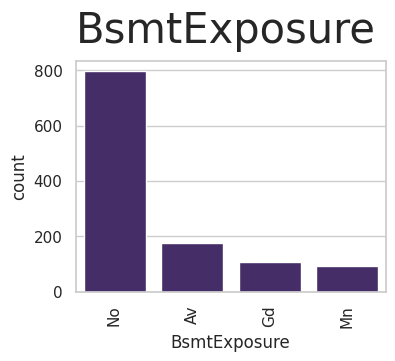

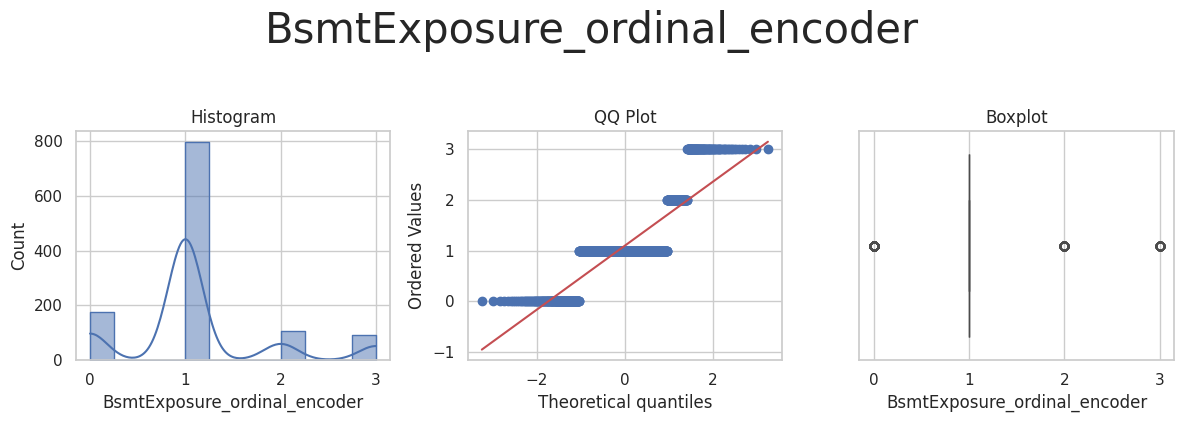



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



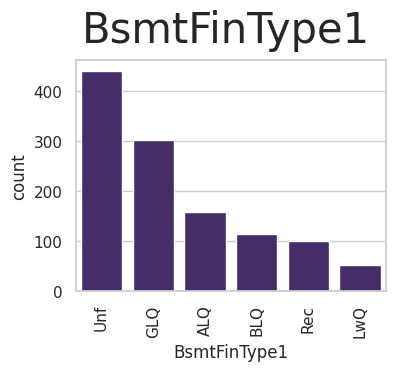

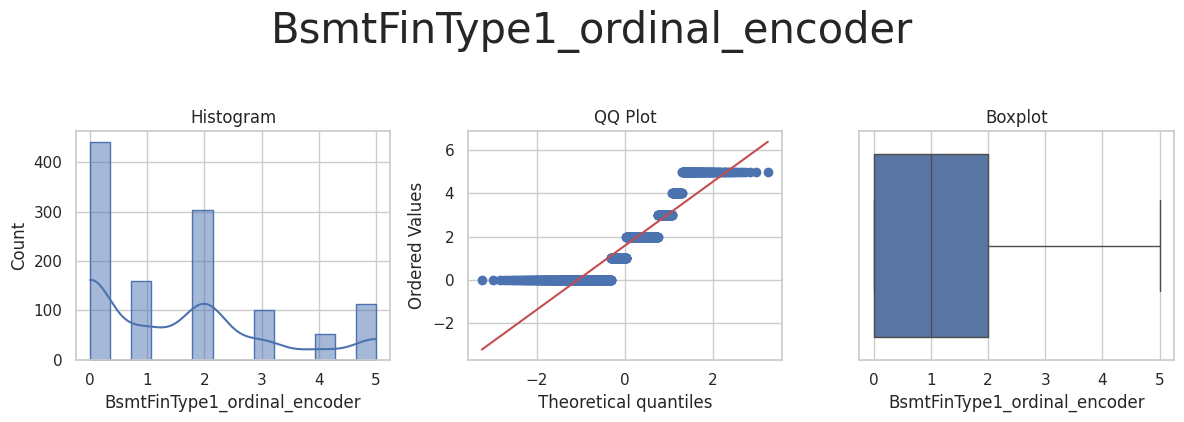



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



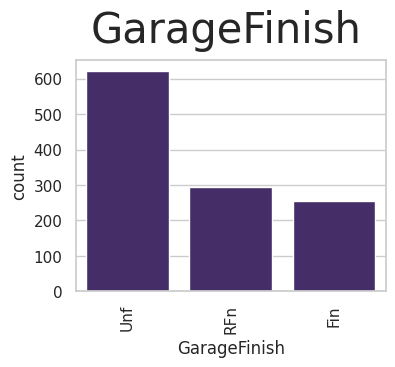

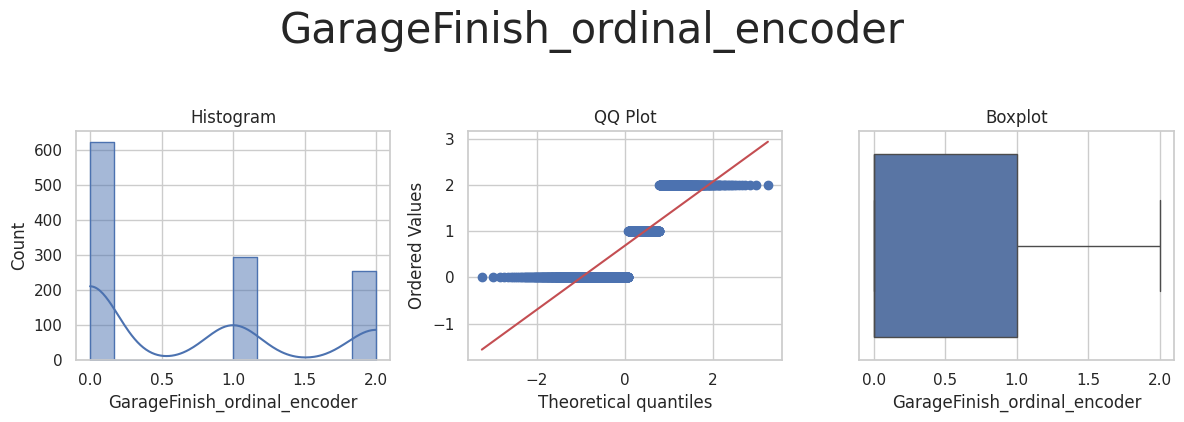



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



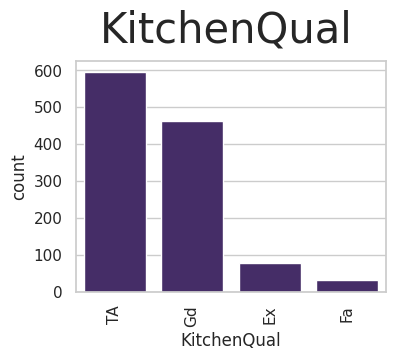

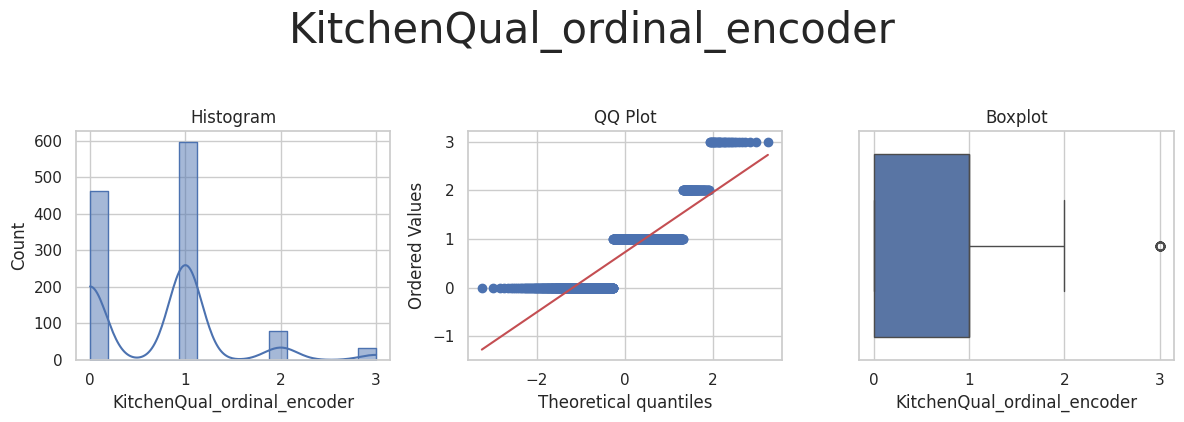

In [10]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

- Apply the selected transformation to the Train and Test set

In [11]:
encoder = OrdinalEncoder(encoding_method="arbitrary", variables=variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.fit_transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


---

### 2. Numerical Transformation

### Numerical Skewness Check

In [12]:
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("outputs/datasets/cleaned/TrainSetCleaned.csv")

print(df.shape)
df.head()


(1168, 22)


1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      1828       0.0           3.0           Av          48          Unf   
1       894       0.0           2.0           No           0          Unf   
2       964       0.0           2.0           No         713          ALQ   
3      1689       0.0           3.0           No        1218          GLQ   
4      1541       0.0           3.0           No           0          Unf   

   BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  LotArea LotFrontage  \
0       1774         774          Unf       2007.0  ...    11694        90.0   
1        894         308          Unf       1962.0  ...     6600        60.0   
2        163         432          Unf       1921.0  ...    13360        80.0   
3        350         857          RFn       2002.0  ...    13265        69.0   
4       1541         843          RFn       2001.0  ...    13704       118.0   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0       452.0          108            5            9         1822       2007   
1         0.0            0            5            5          894       1962   
2         0.0            0            7            5          876       1921   
3       148.0           59            5            8         1568       2002   
4       150.0           81            5            7         1541       2001   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  
3          2002     271000  
4          2002     205000  

[5 rows x 22 columns]

In [13]:
# Extract numeric columns
numeric_columns = df.select_dtypes(include=["number"]).columns.tolist()

# Calculate skewness for each numerical column
skewness = df[numeric_columns].skew().sort_values(ascending=False)

# Display skewness values
print("Skewness of numerical features:")
print(skewness)

# Select variables with high skewness (|skewness| > 0.75)
variables_engineering = skewness[abs(skewness) > 0.75].index.tolist()
print("\nVariables recommended for log or power transformation:")
print(variables_engineering)


Skewness of numerical features:
LotArea         12.140078
MasVnrArea       2.721576
OpenPorchSF      2.404350
LotFrontage      1.915069
SalePrice        1.750106
GrLivArea        1.076764
1stFlrSF         0.961592
BsmtUnfSF        0.882065
2ndFlrSF         0.869199
BsmtFinSF1       0.764193
OverallCond      0.680104
TotalBsmtSF      0.591485
BedroomAbvGr     0.235067
GarageArea       0.174311
OverallQual      0.169894
YearRemodAdd    -0.491409
YearBuilt       -0.613111
GarageYrBlt     -0.672467
dtype: float64

Variables recommended for log or power transformation:
['LotArea', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'SalePrice', 'GrLivArea', '1stFlrSF', 'BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF1']


In [14]:
variables_engineering = [
    'LotArea', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage',
    'GrLivArea', '1stFlrSF', 'BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF1'
]

- 'SalePrice' is the target variable, so it should not be included in FeatureEngineeringAnalysis()


In [15]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(5)

LotArea  MasVnrArea  OpenPorchSF  LotFrontage  GrLivArea  1stFlrSF  \
0    11694       452.0          108         90.0       1828      1828   
1     6600         0.0            0         60.0        894       894   
2    13360         0.0            0         80.0        964       964   
3    13265       148.0           59         69.0       1689      1689   
4    13704       150.0           81        118.0       1541      1541   

   BsmtUnfSF  2ndFlrSF  BsmtFinSF1  
0       1774       0.0          48  
1        894       0.0           0  
2        163       0.0         713  
3        350       0.0        1218  
4       1541       0.0           0

In [16]:
TrainSet.isnull().sum().sort_values(ascending=False).head(10)


1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
dtype: int64

* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



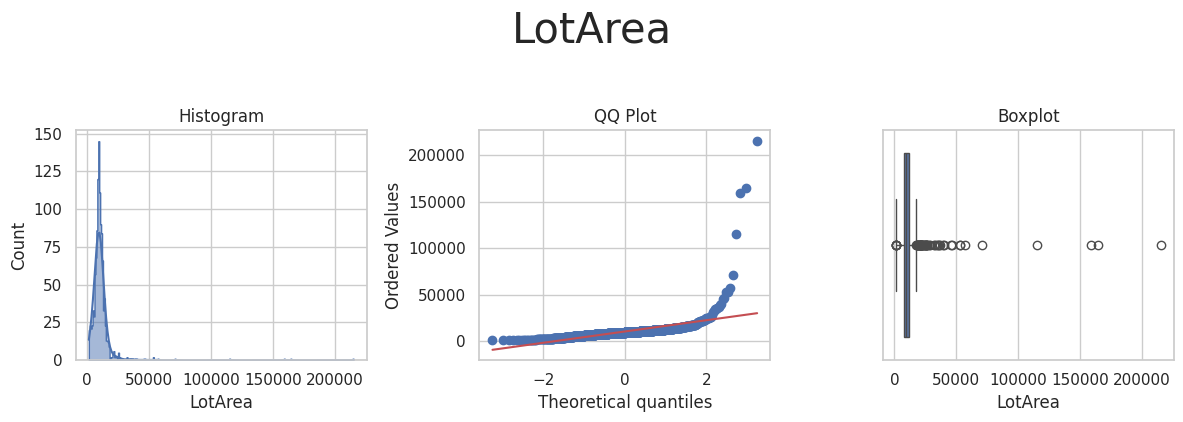

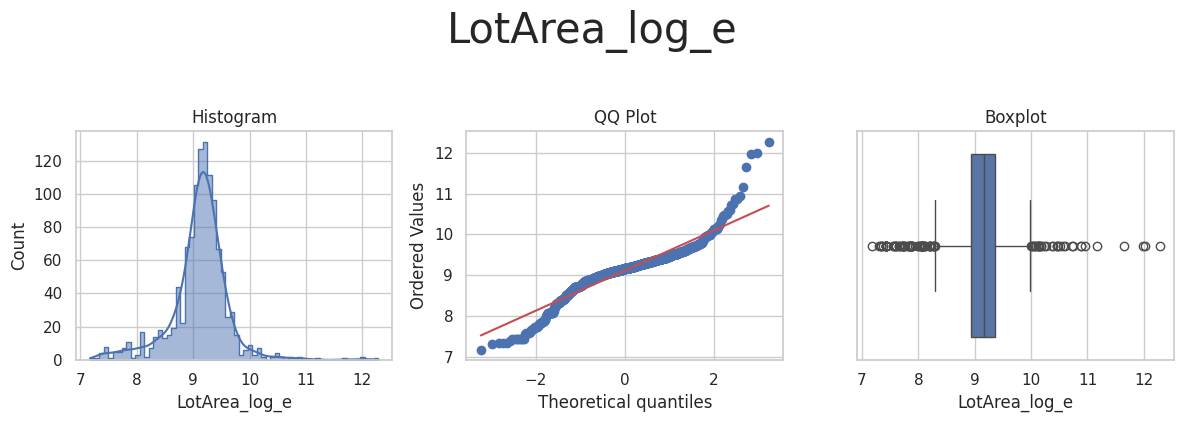

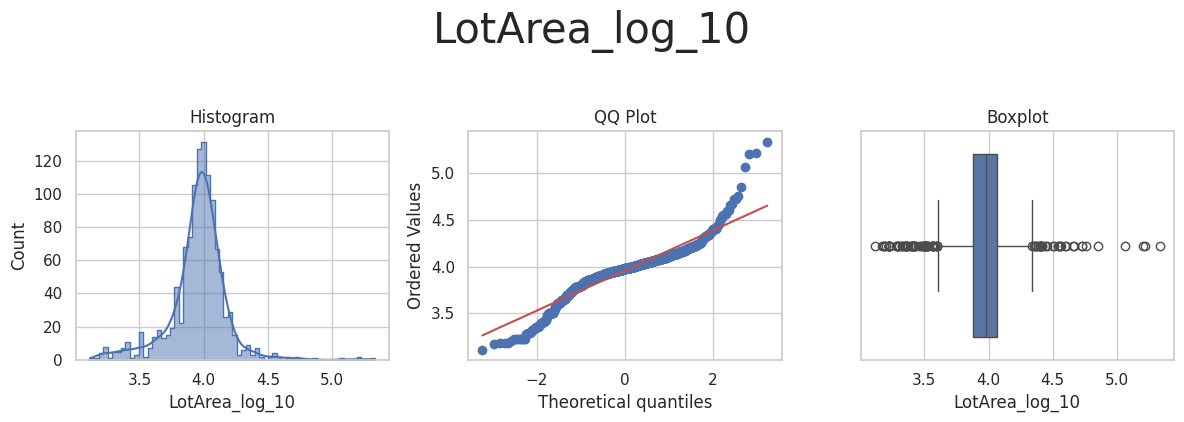

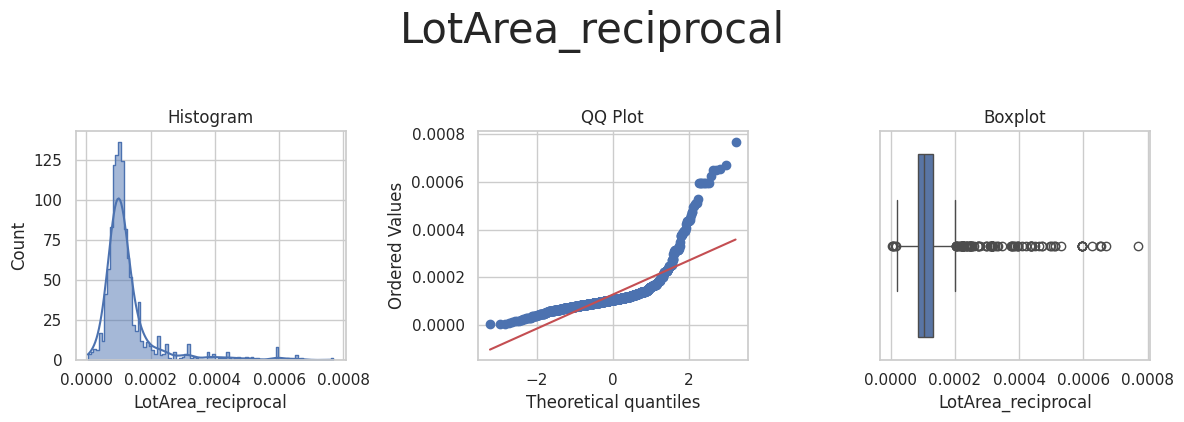

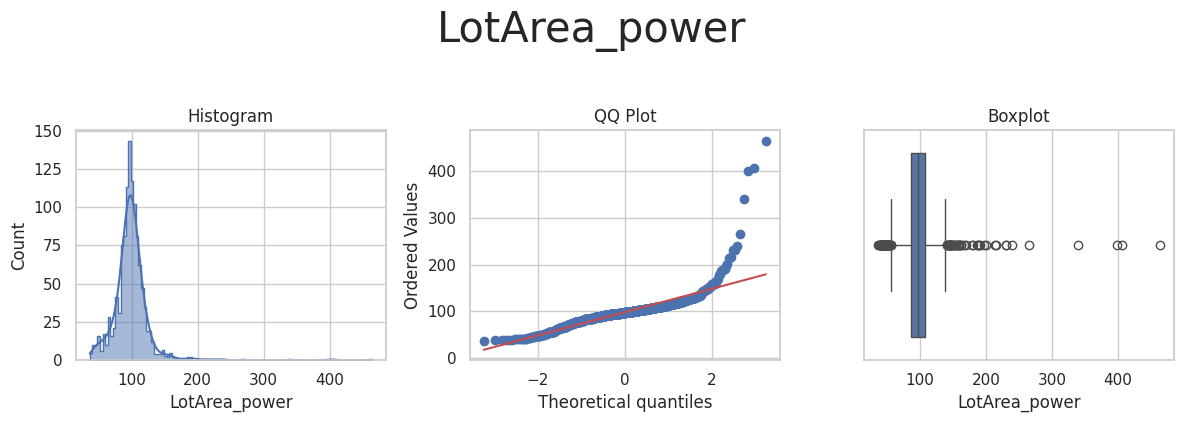

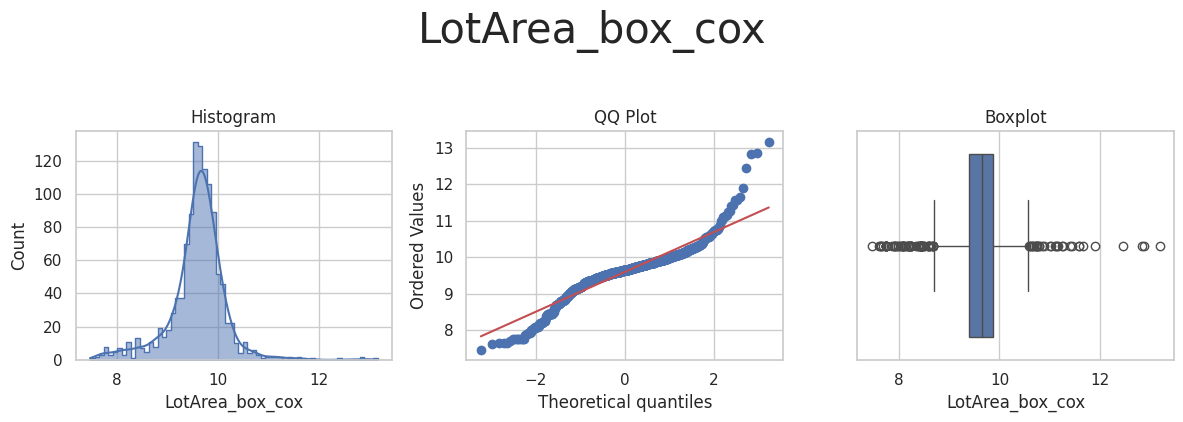

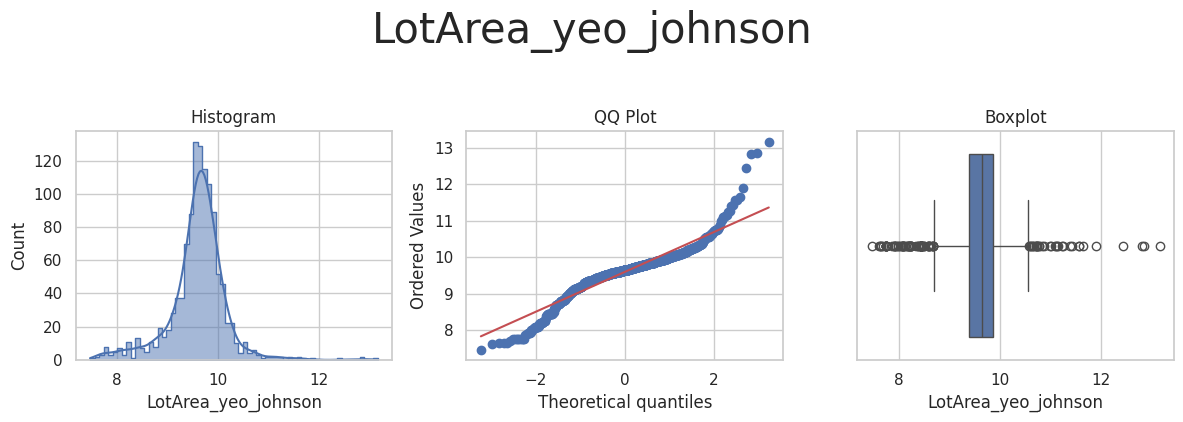



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



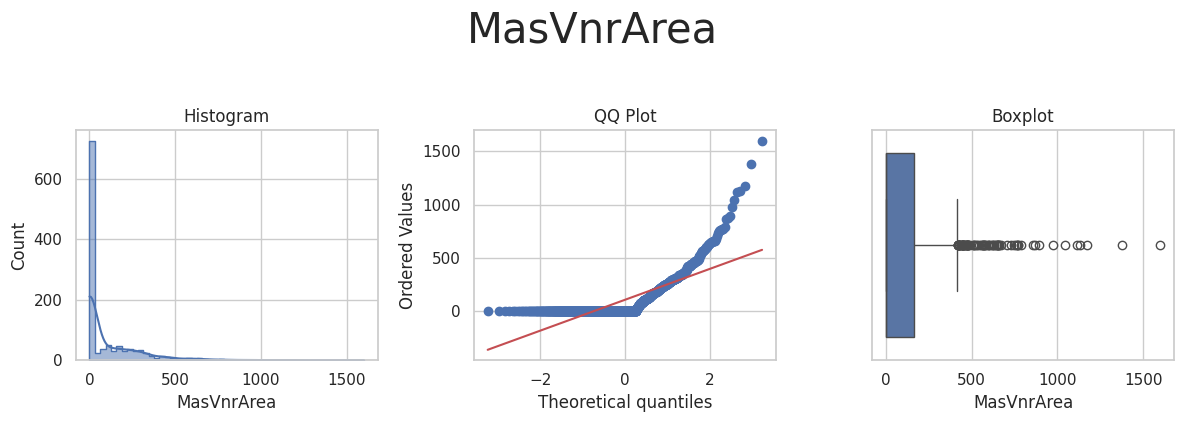

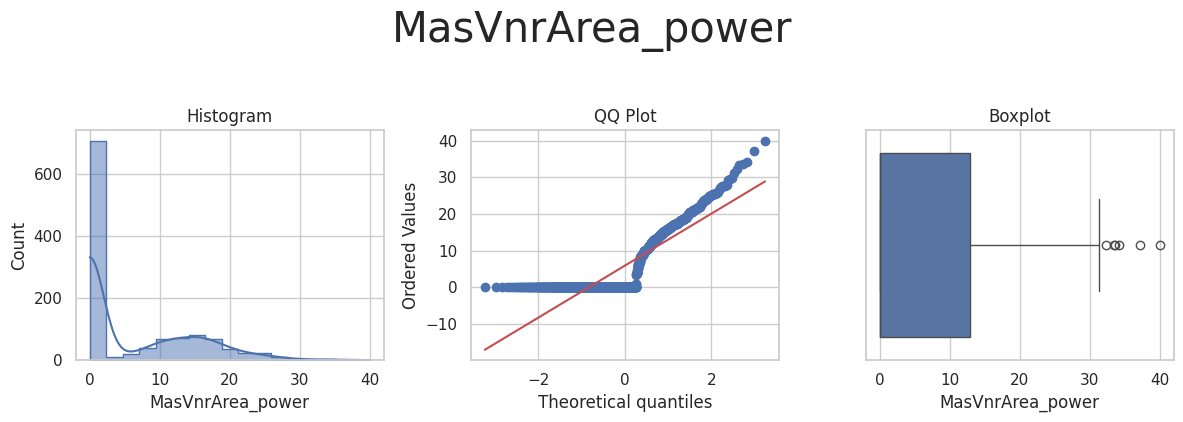

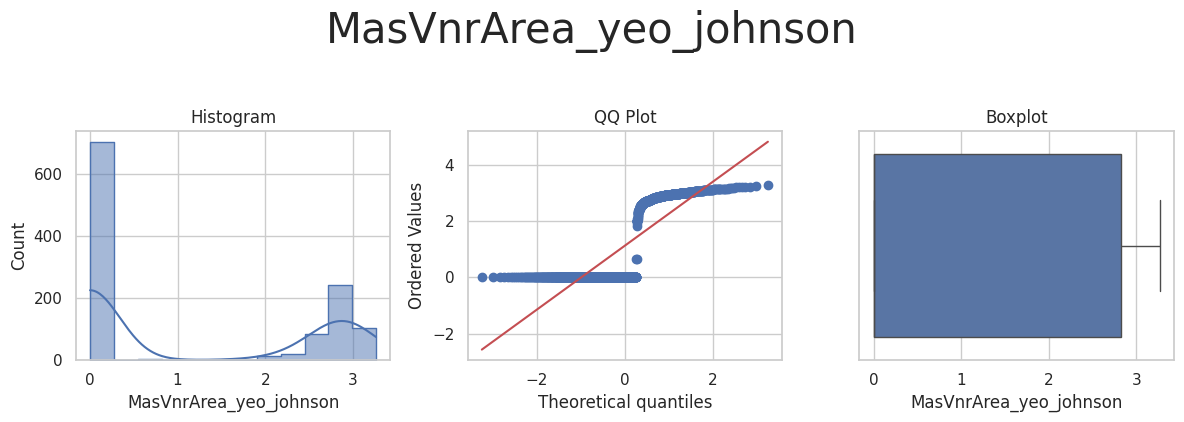



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



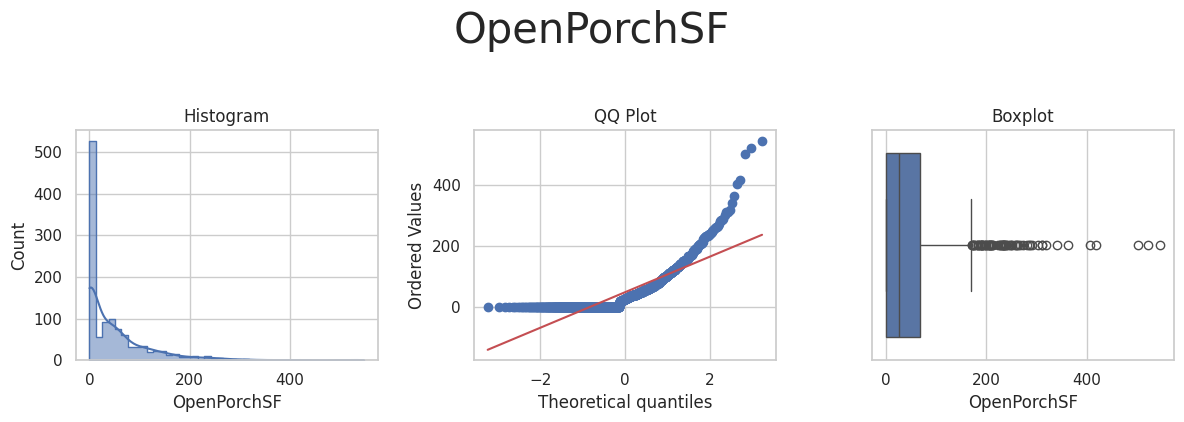

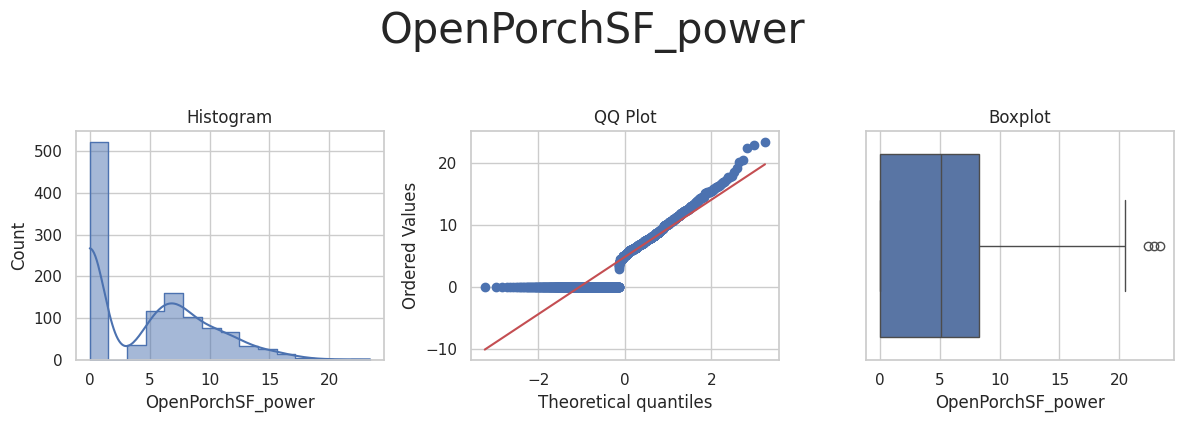

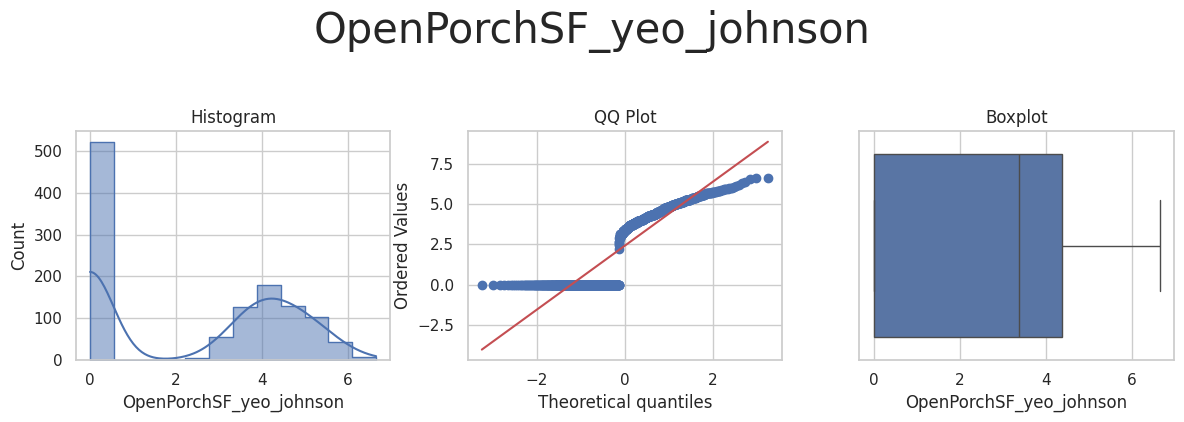



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



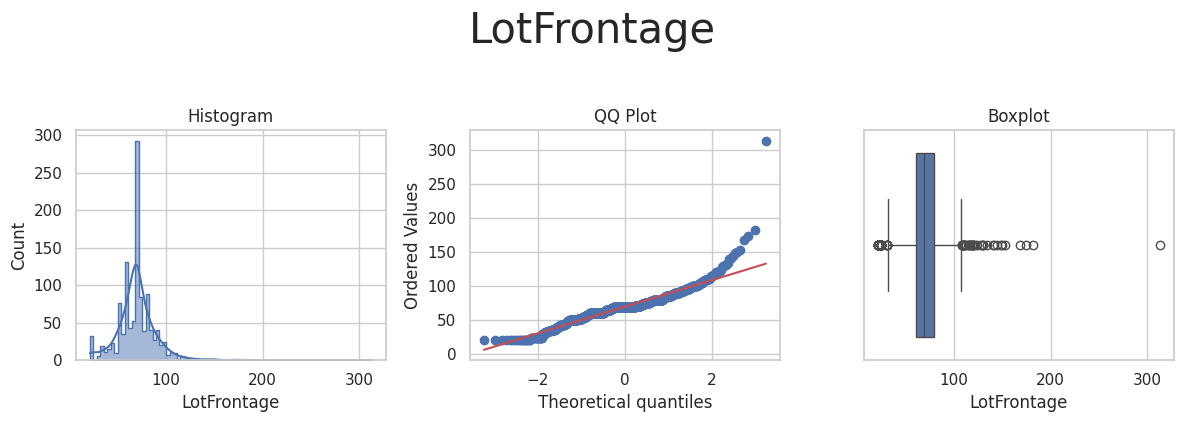

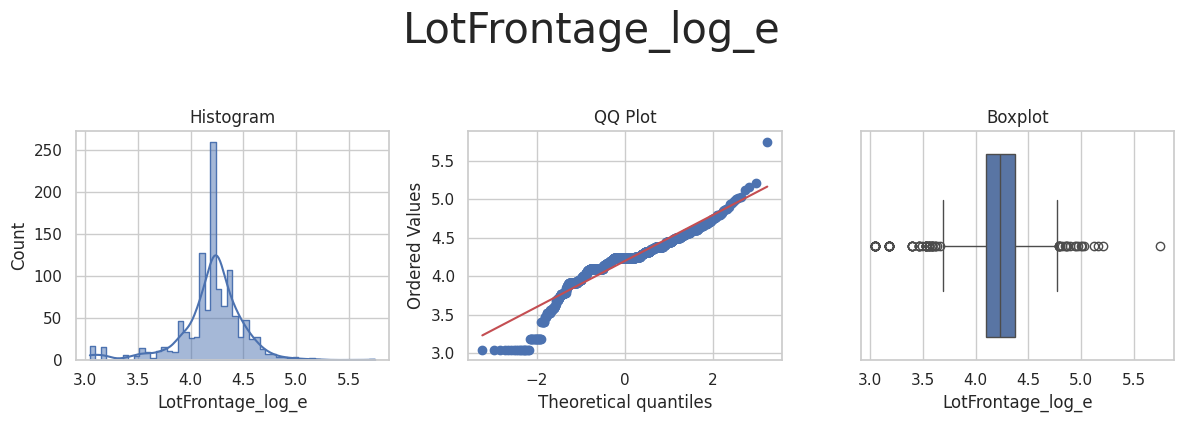

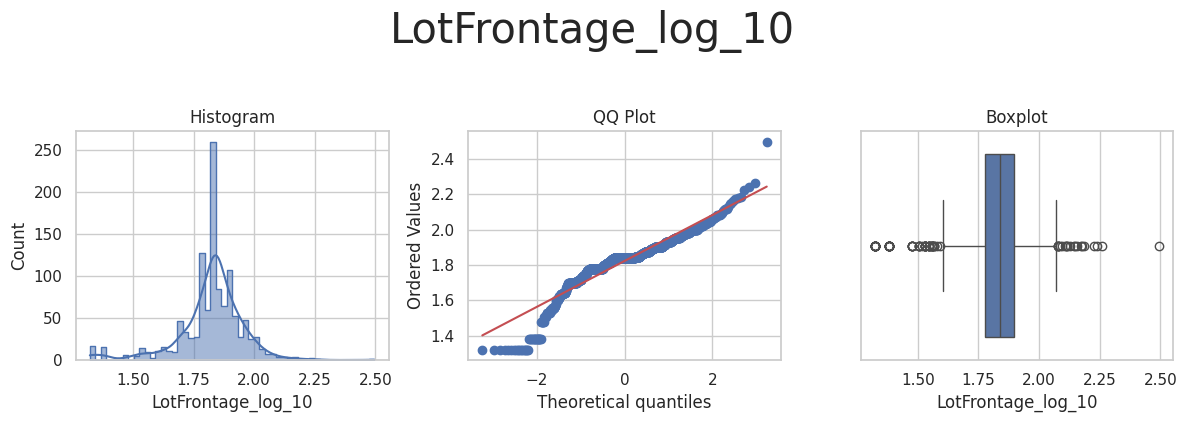

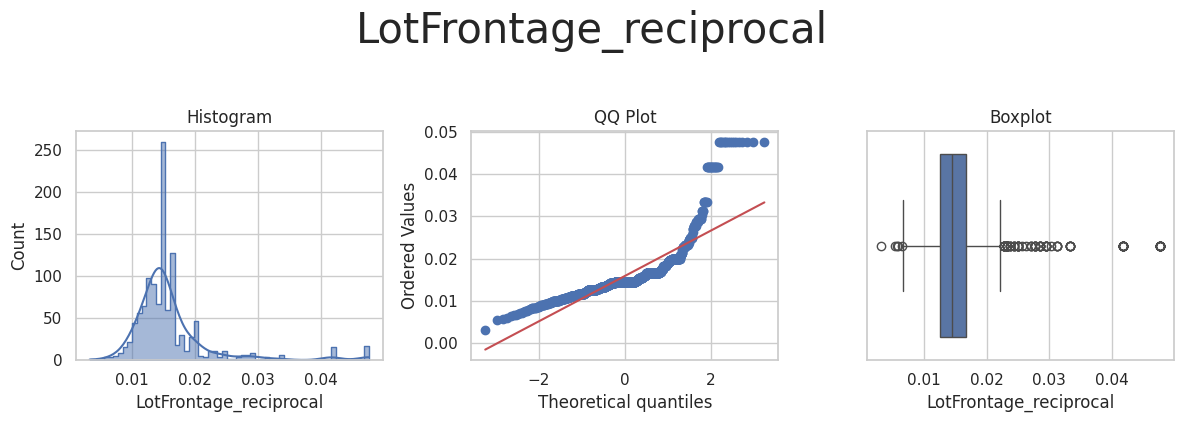

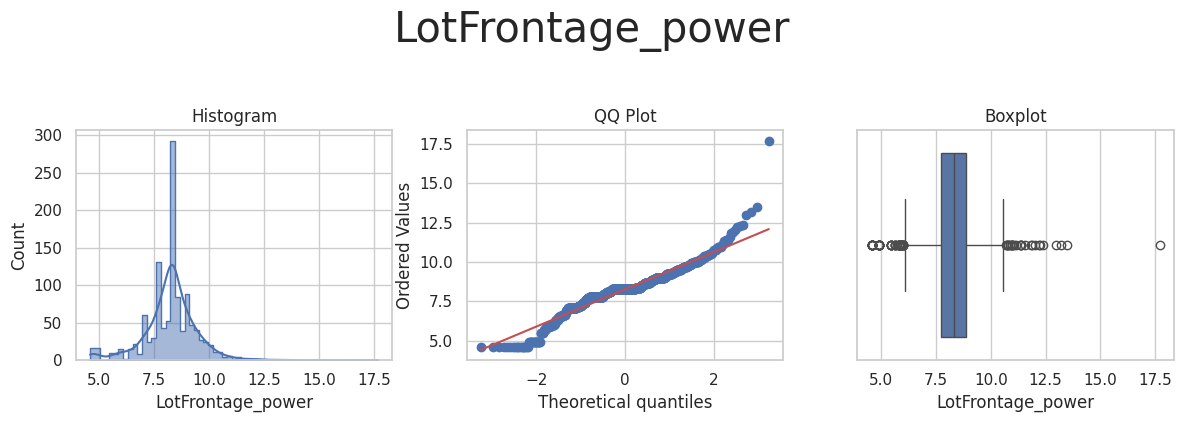

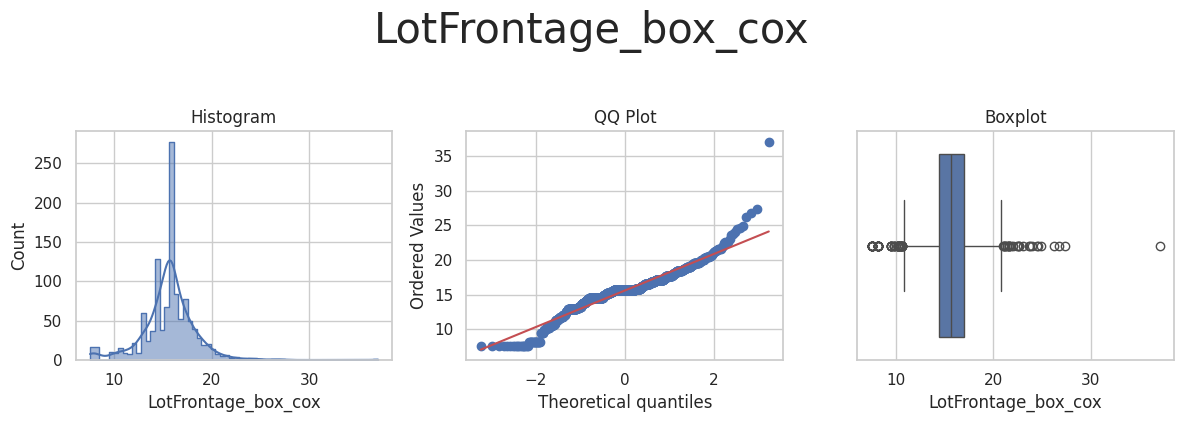

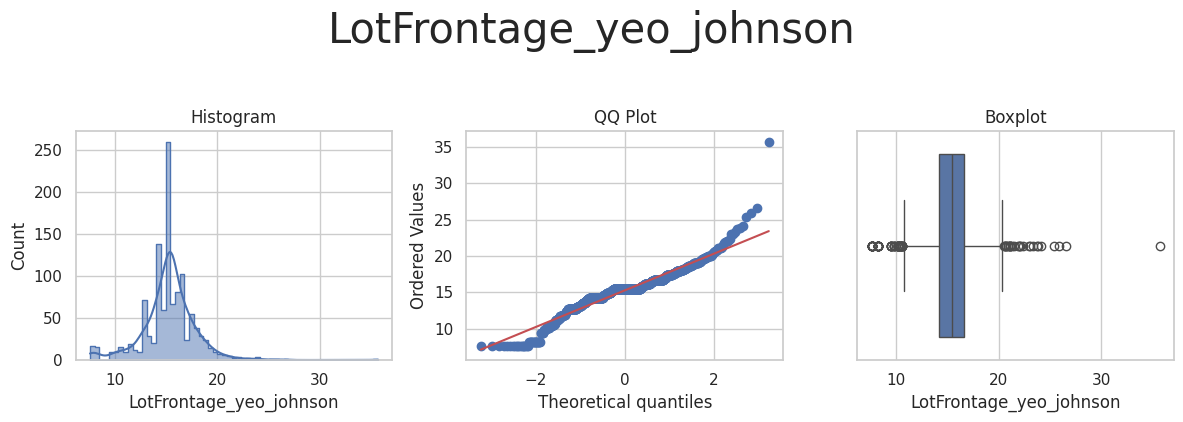



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



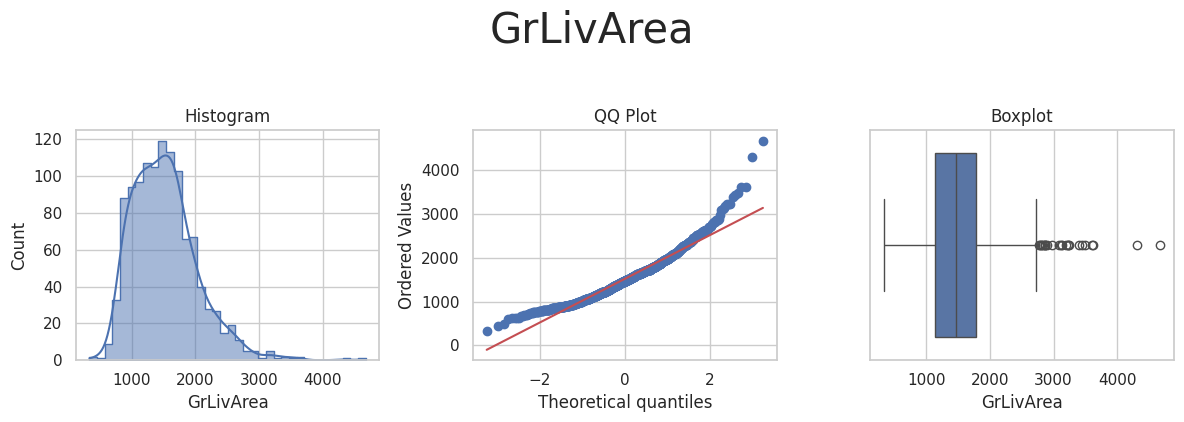

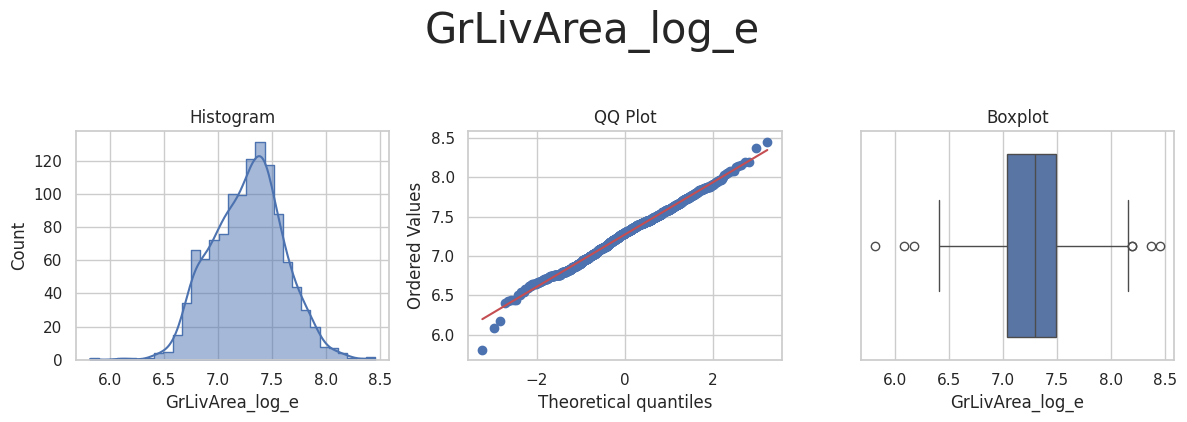

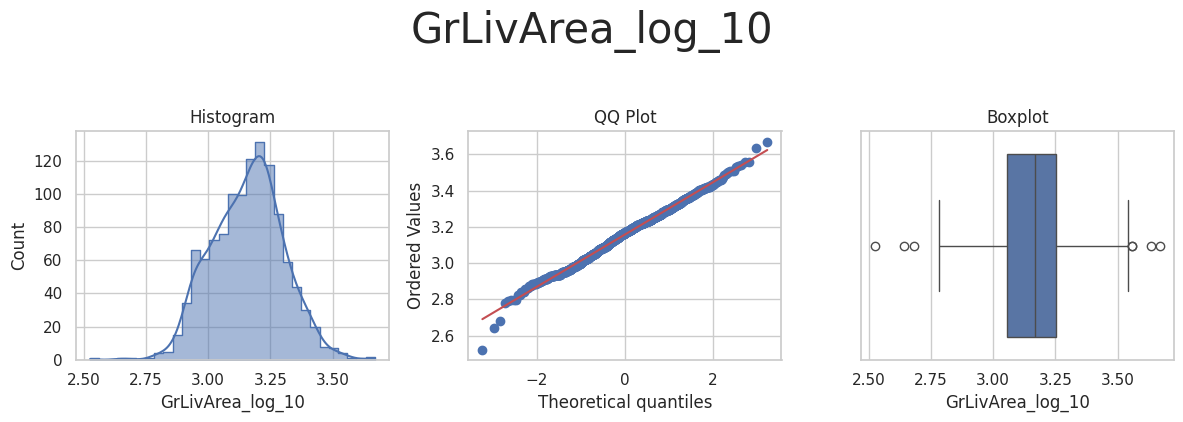

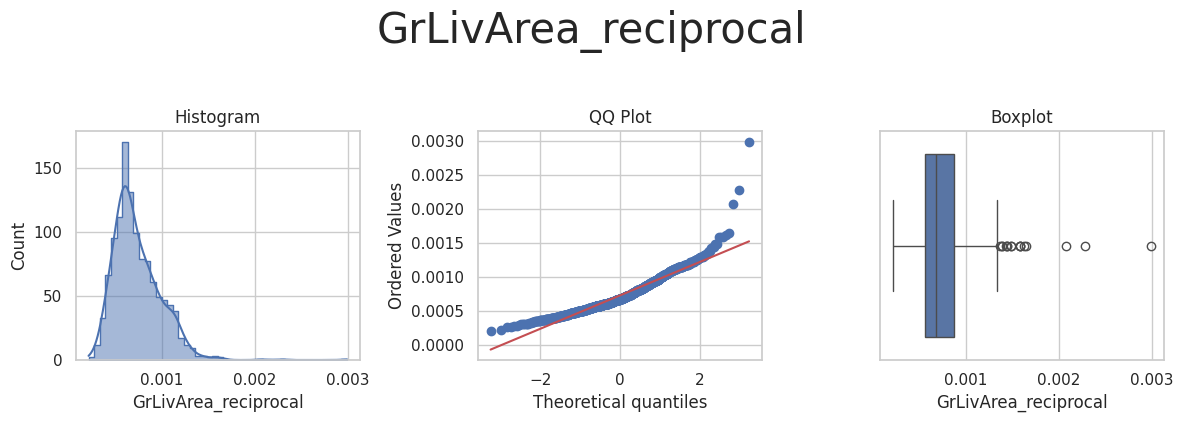

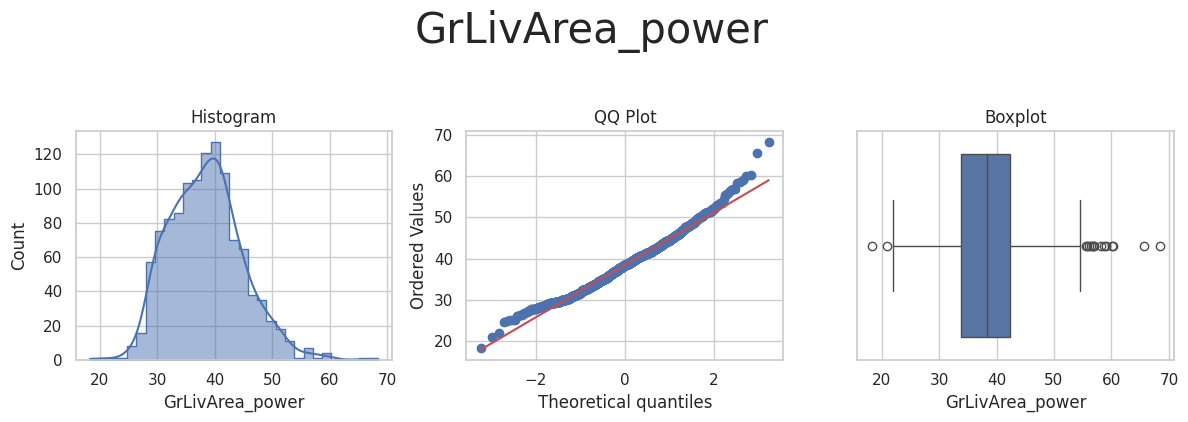

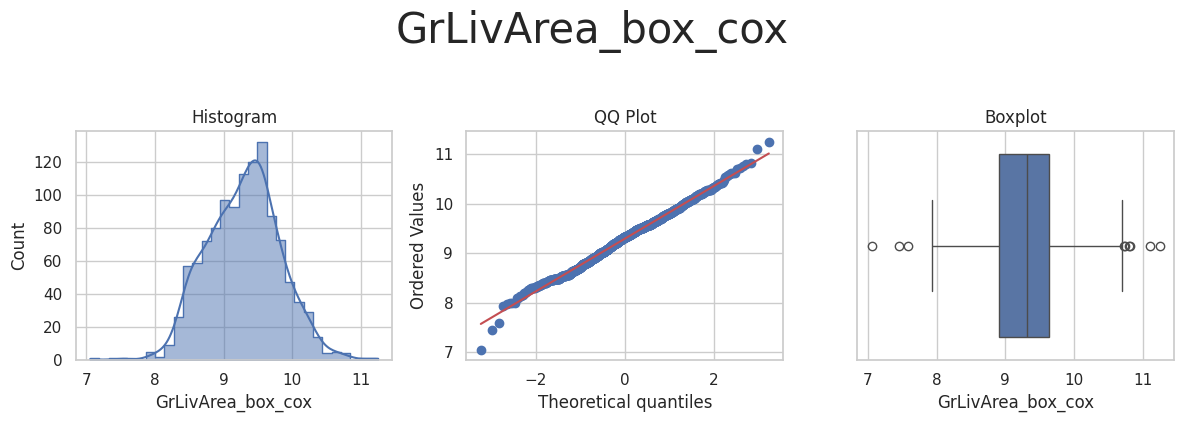

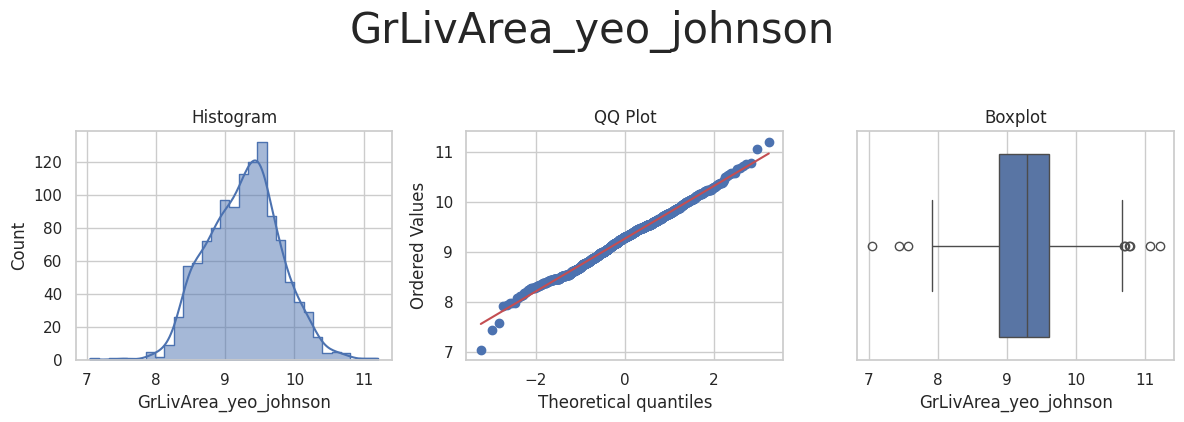



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



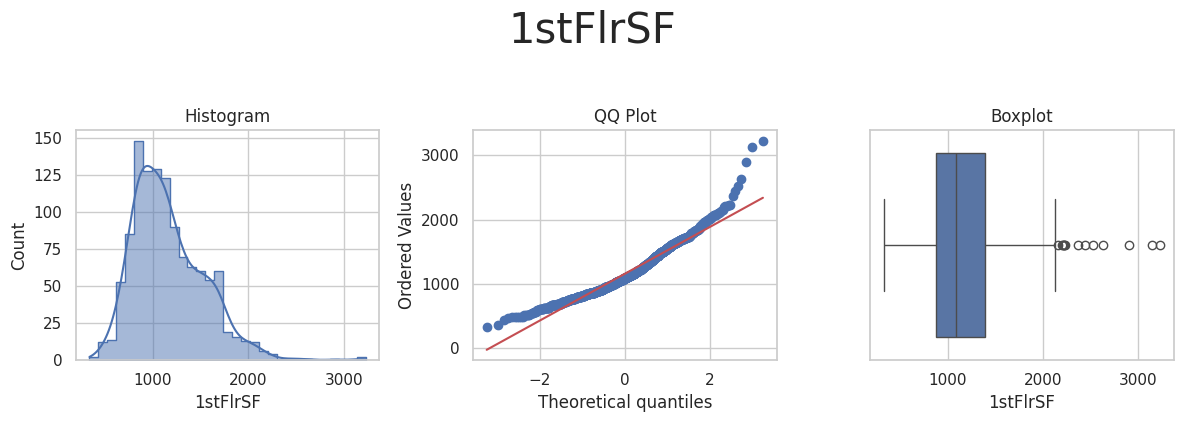

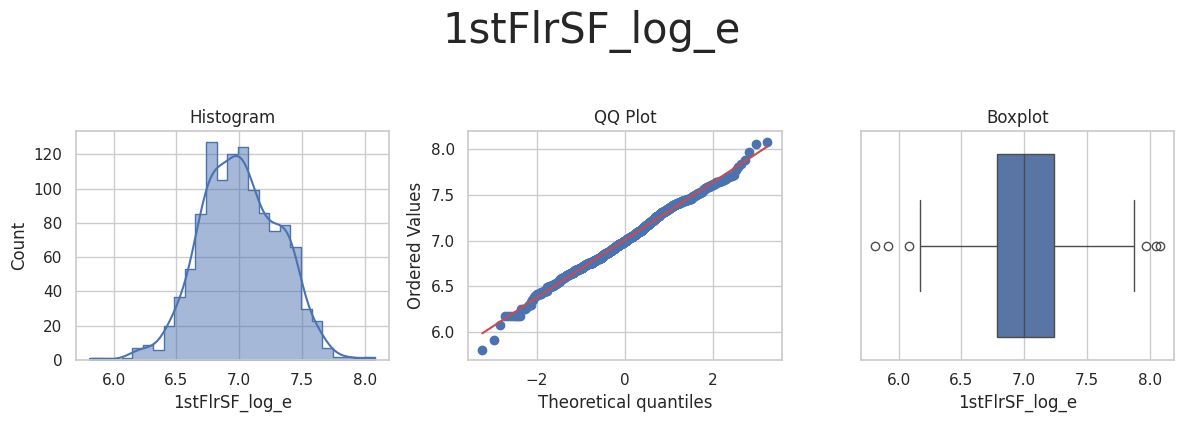

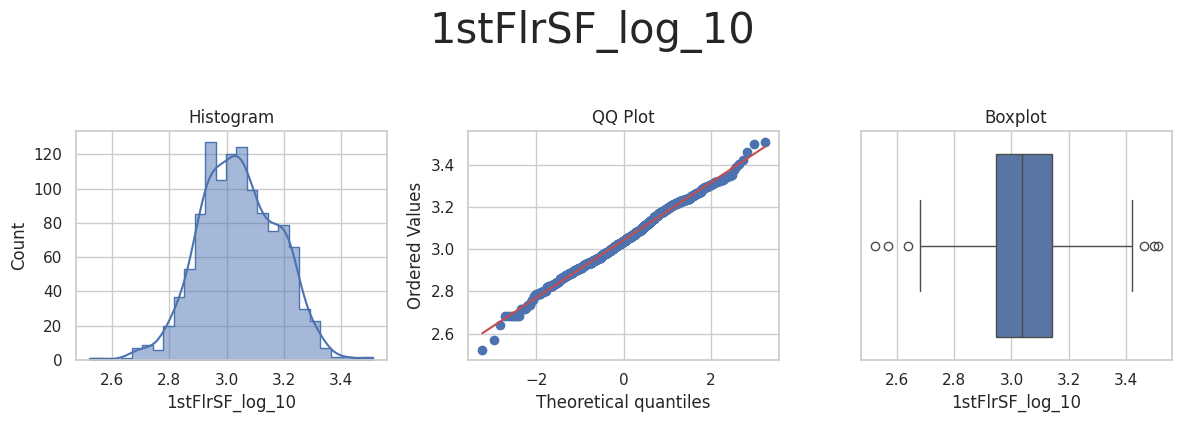

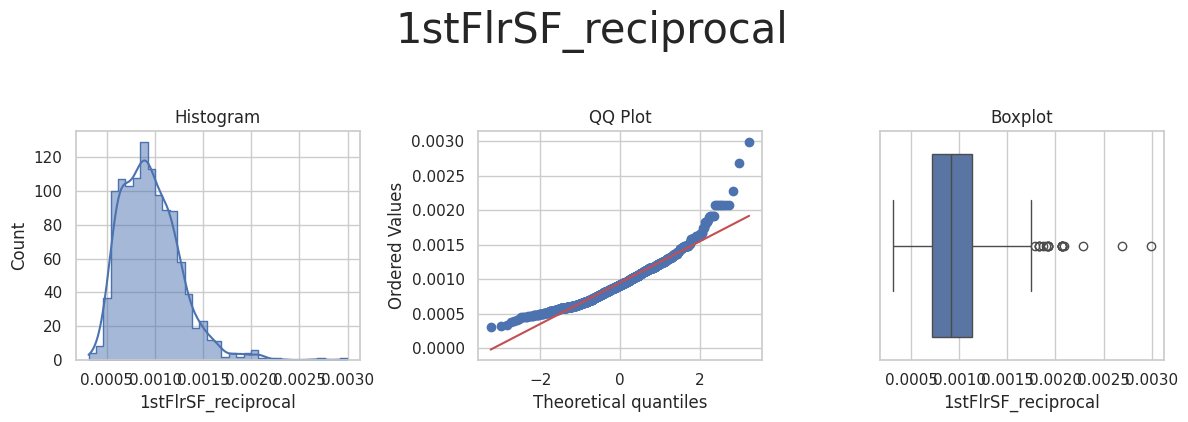

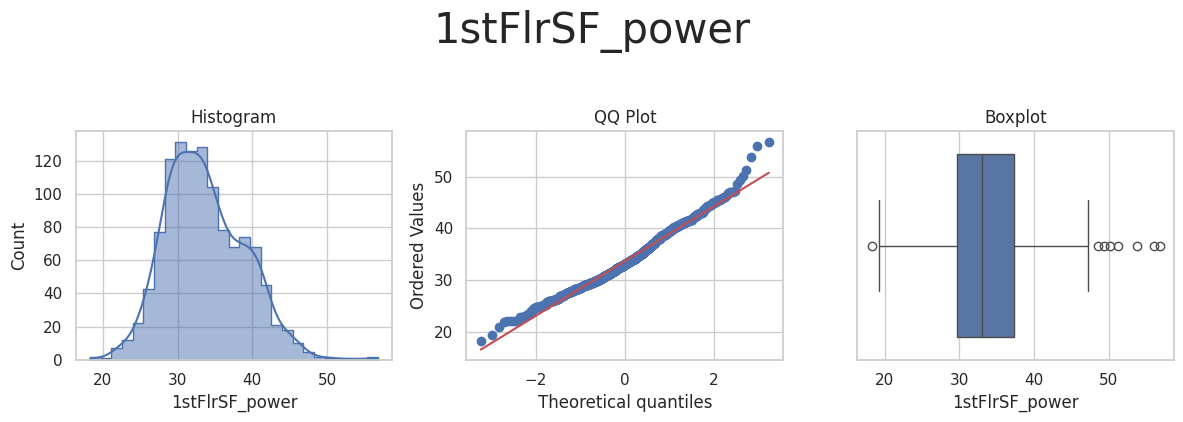

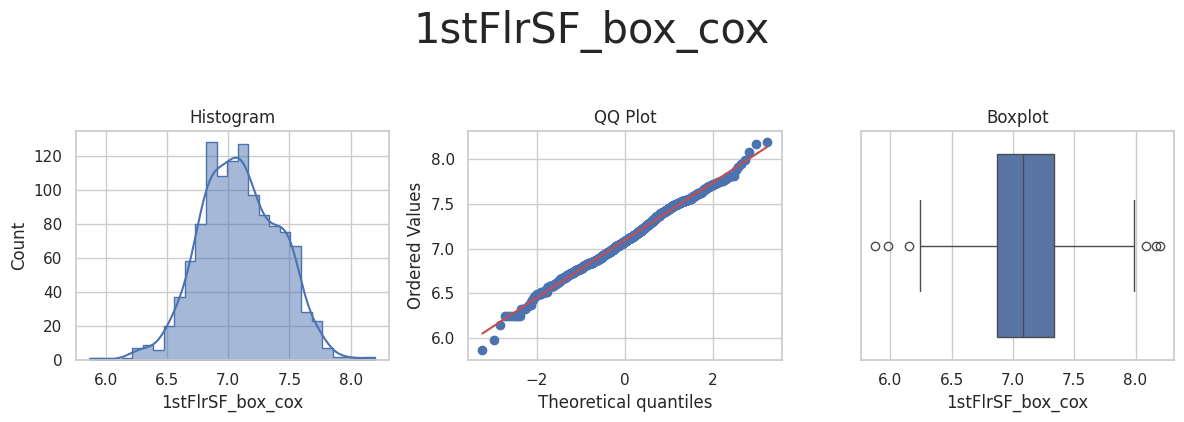

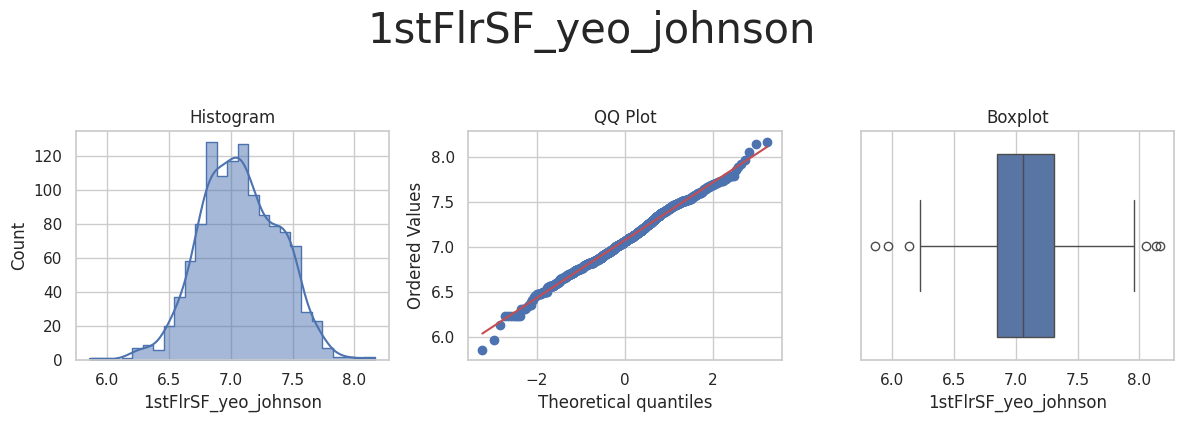



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_power', 'BsmtUnfSF_yeo_johnson'] 



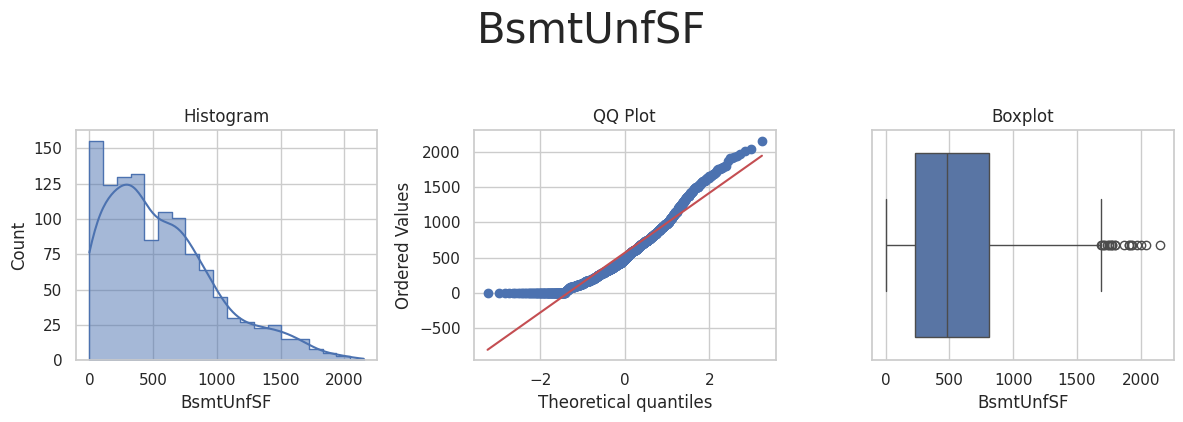

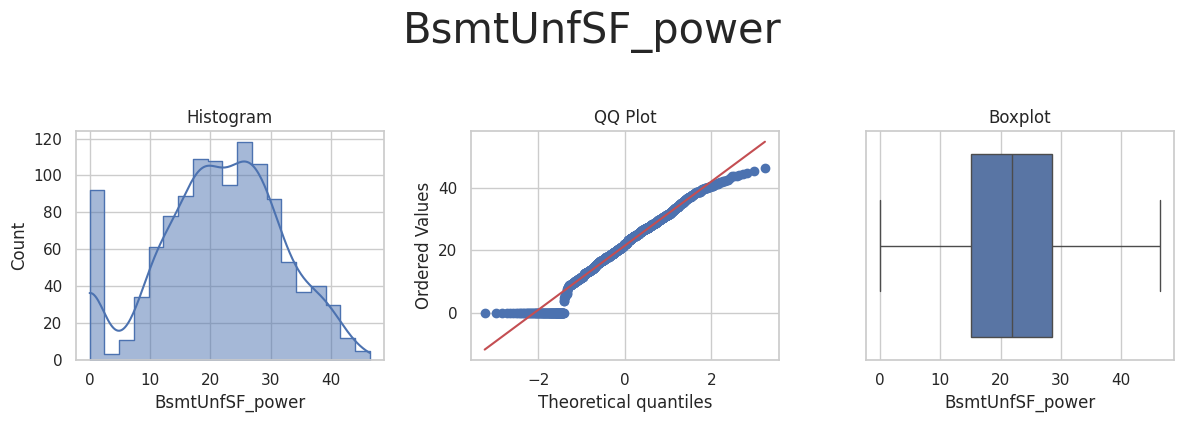

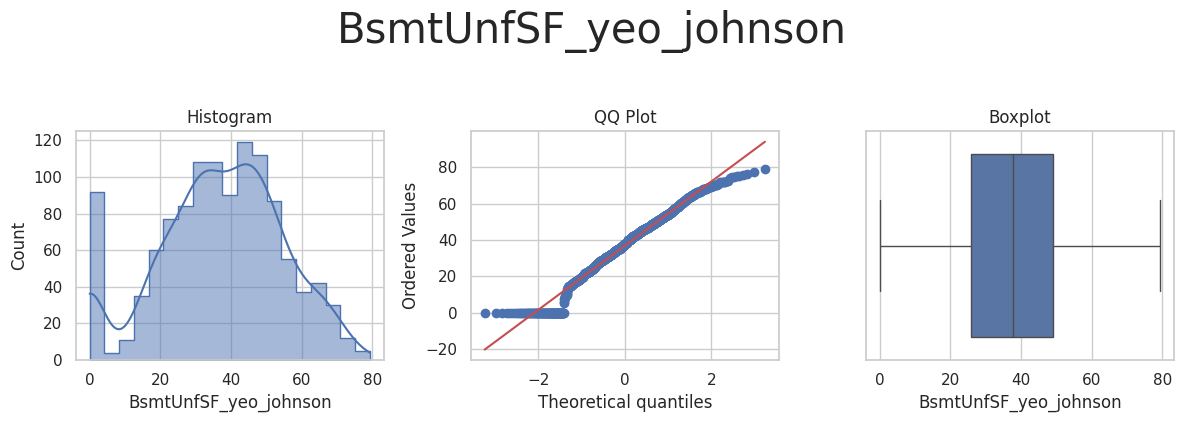



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



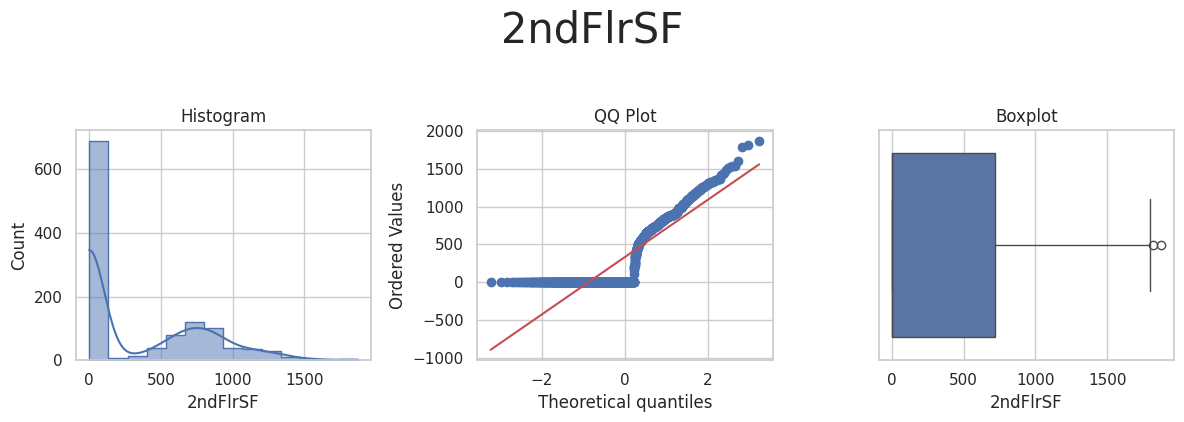

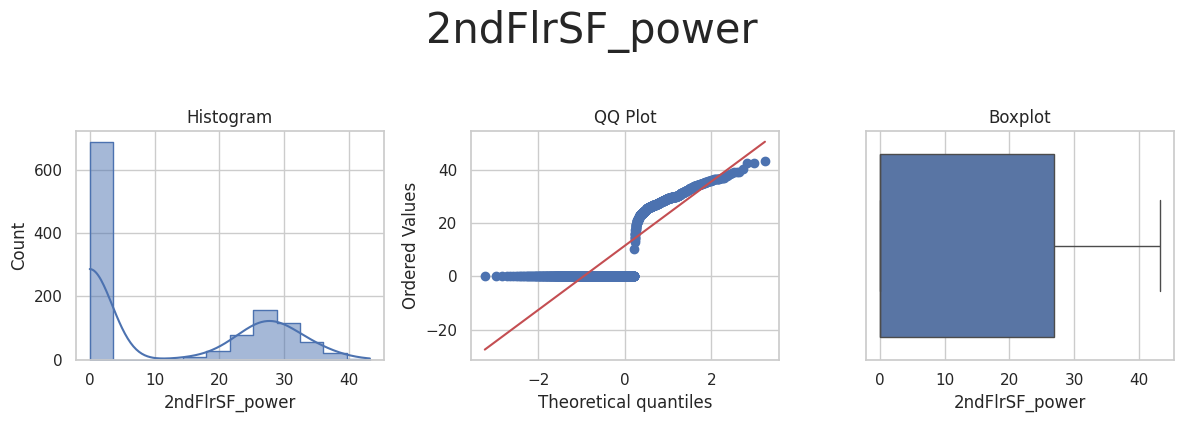

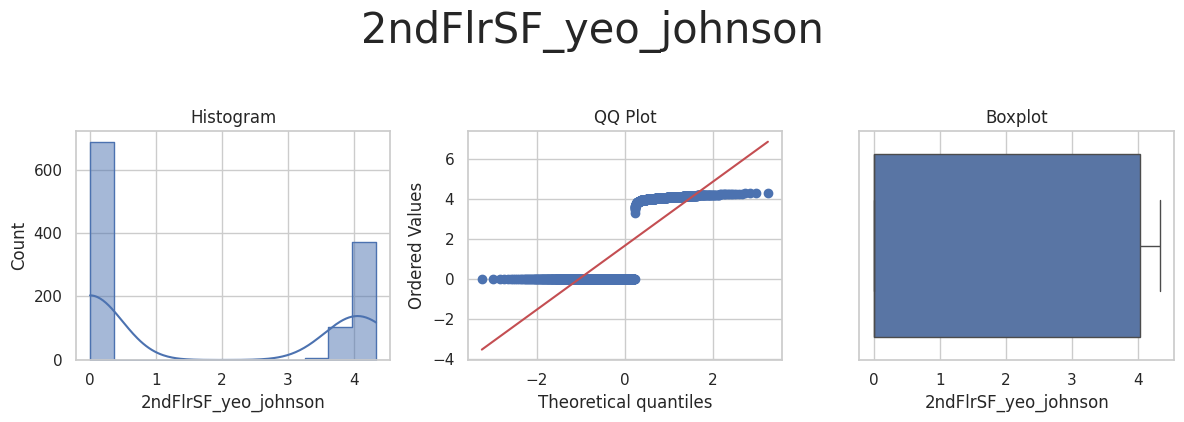



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_power', 'BsmtFinSF1_yeo_johnson'] 



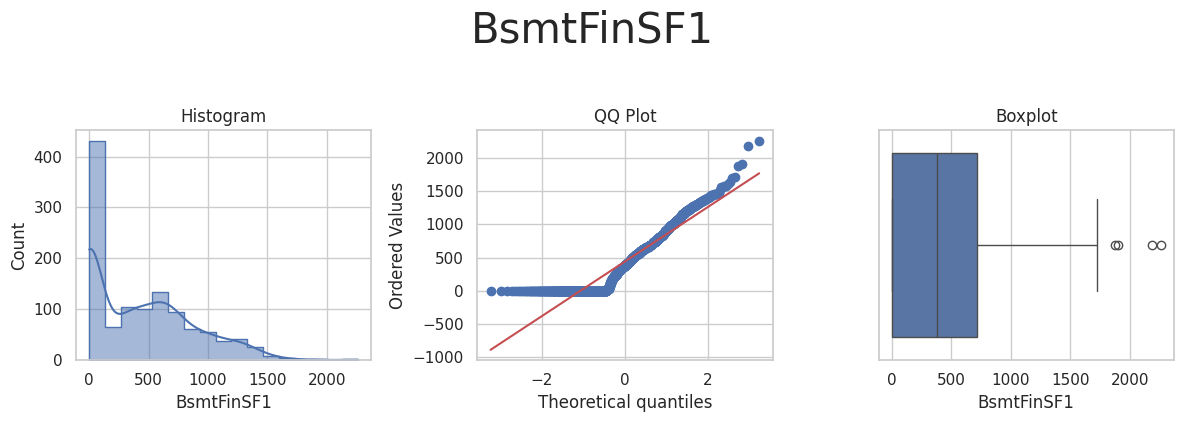

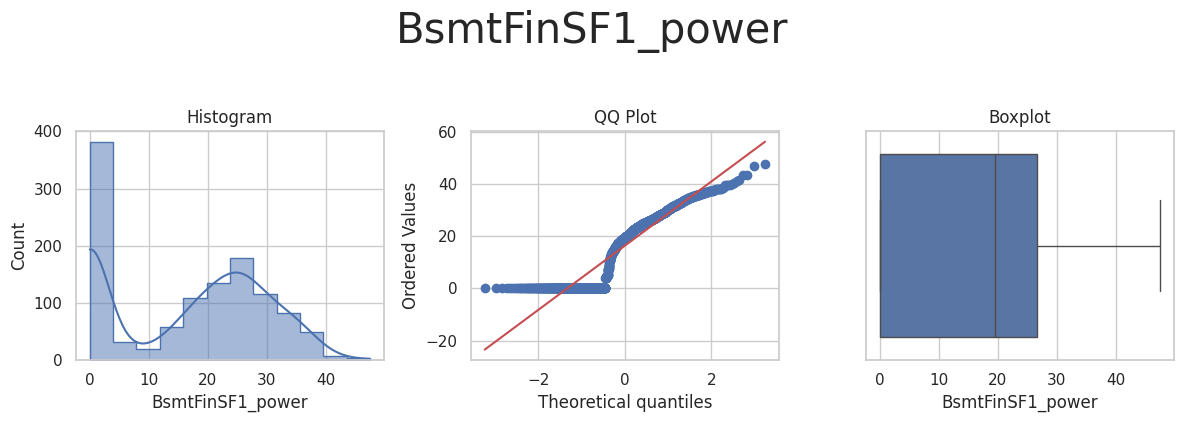

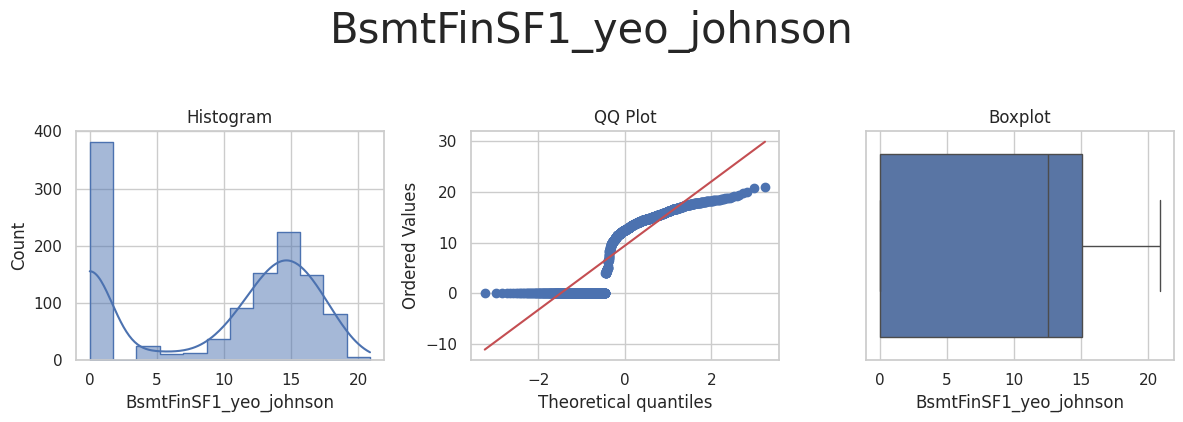

In [17]:
df_engineering = FeatureEngineeringAnalysis(
    df=df_engineering, analysis_type="numerical"
)

In [18]:
from feature_engine.transformation import LogTransformer, PowerTransformer

# Only strictly positive variables for log transform
log_transform_vars = ['LotArea', 'GrLivArea']

# Variables that may include zero, or are moderately skewed
power_transform_vars = [
    'MasVnrArea', 'OpenPorchSF', 'LotFrontage',
    '1stFlrSF', 'BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF1'
]

lt = LogTransformer(variables=log_transform_vars)
pt = PowerTransformer(variables=power_transform_vars)

# Apply transformations
transformers = [lt, pt]
for t in transformers:
    TrainSet = t.fit_transform(TrainSet)
    TestSet = t.transform(TestSet)

print("* Numerical transformation done!")


* Numerical transformation done!


---

3. Winsorizer

In [19]:
# Define the variables you want to check
variables_to_check = [
    "GarageArea",
    "LotArea",
    "LotFrontage",
    "MasVnrArea",
    "OpenPorchSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF"
]

# Loop through each variable and display describe()
for var in variables_to_check:
    print(f"\n=== {var} ===")
    print(TrainSet[var].describe())



=== GarageArea ===
count    1168.000000
mean      473.632705
std       209.442320
min         0.000000
25%       336.000000
50%       477.500000
75%       576.000000
max      1390.000000
Name: GarageArea, dtype: float64

=== LotArea ===
count    1168.000000
mean        9.112796
std         0.518370
min         7.170120
25%         8.934521
50%         9.160362
75%         9.358890
max        12.279532
Name: LotArea, dtype: float64

=== LotFrontage ===
count    1168.000000
mean        8.246471
std         1.224567
min         4.582576
25%         7.745967
50%         8.306624
75%         8.888194
max        17.691806
Name: LotFrontage, dtype: float64

=== MasVnrArea ===
count    1168.000000
mean        5.948203
std         8.223519
min         0.000000
25%         0.000000
50%         0.000000
75%        12.893786
max        40.000000
Name: MasVnrArea, dtype: float64

=== OpenPorchSF ===
count    1168.000000
mean        4.818335
std         4.984922
min         0.000000
25%         0.0

In [20]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

LotArea  MasVnrArea  OpenPorchSF  LotFrontage  GrLivArea   1stFlrSF  \
0  9.366831   21.260292    10.392305     9.486833   7.510978  42.755117   
1  8.794825    0.000000     0.000000     7.745967   6.795706  29.899833   
2  9.500020    0.000000     0.000000     8.944272   6.871091  31.048349   

   BsmtUnfSF  2ndFlrSF  BsmtFinSF1  
0  42.118879       0.0    6.928203  
1  29.899833       0.0    0.000000  
2  12.767145       0.0   26.702060

* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_iqr'] 



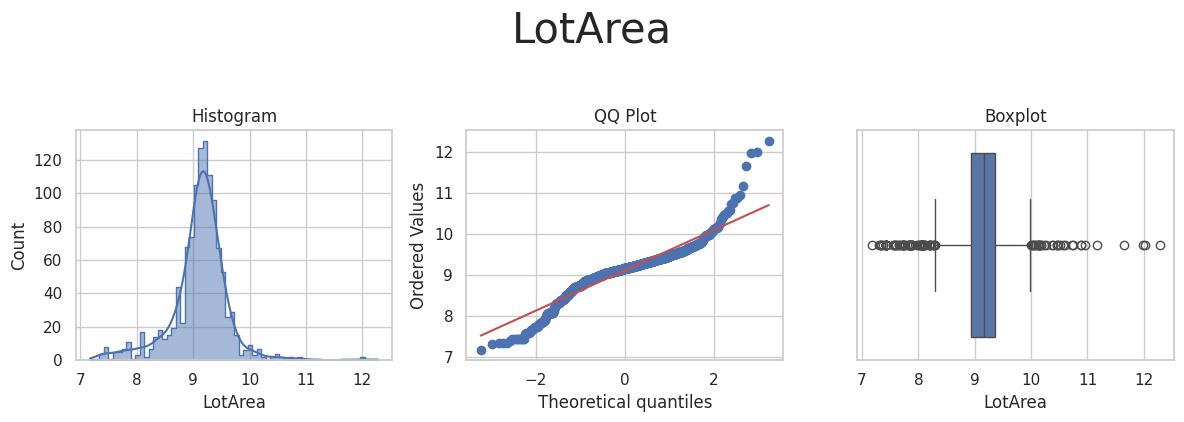

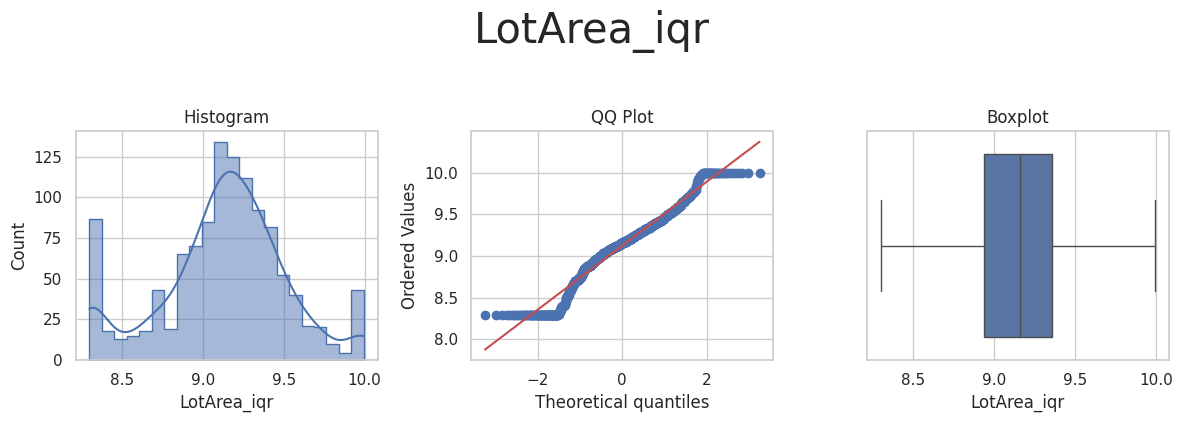



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_iqr'] 



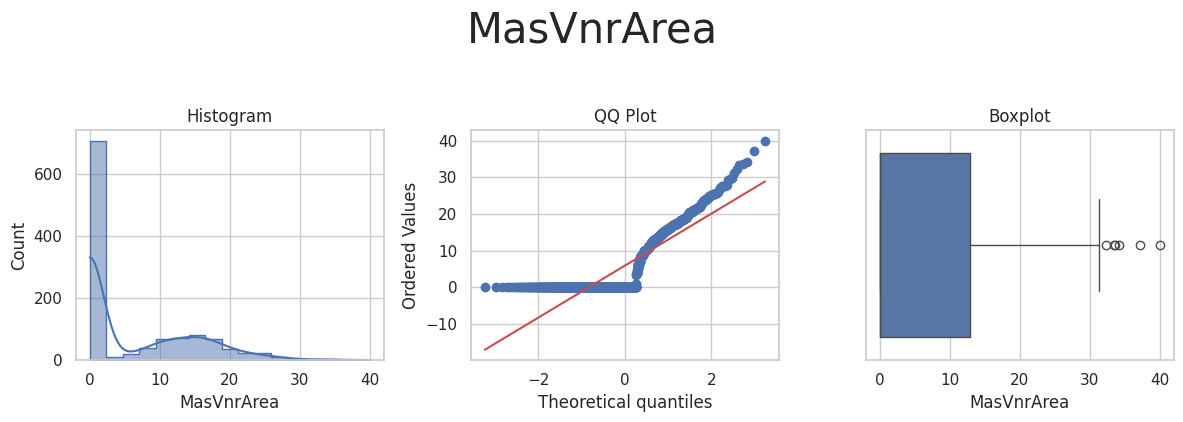

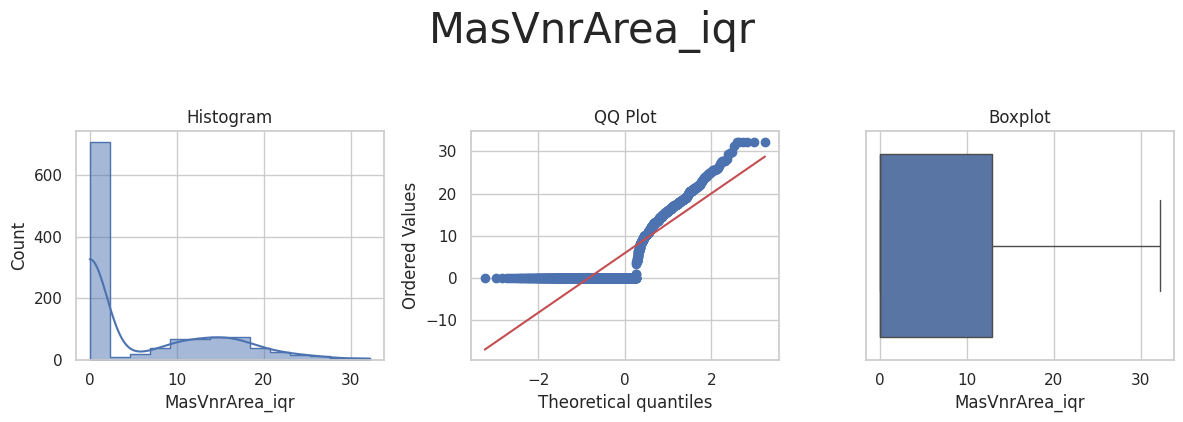



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_iqr'] 



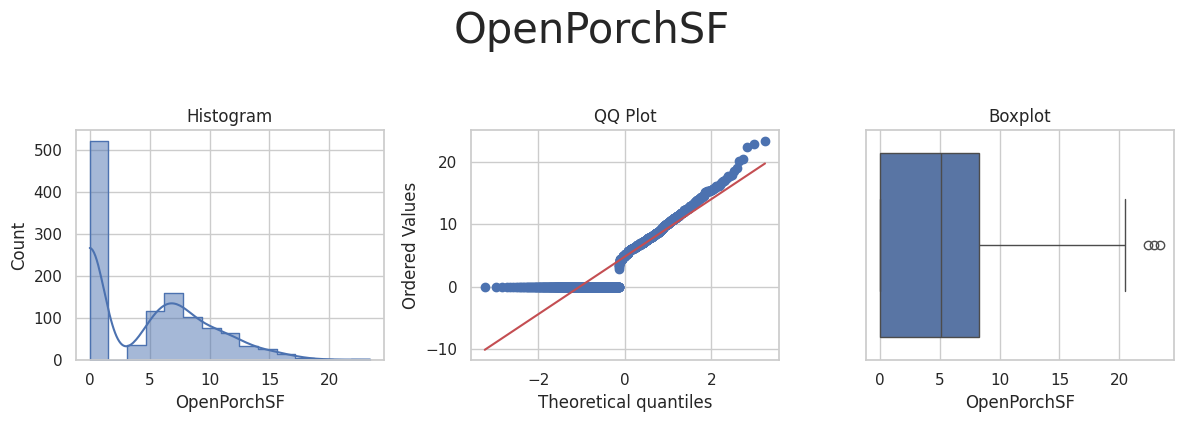

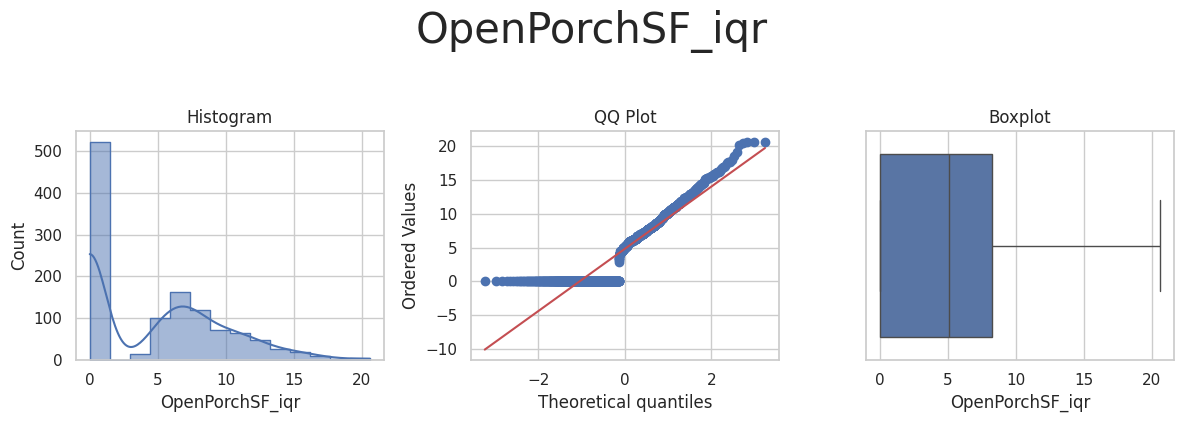



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_iqr'] 



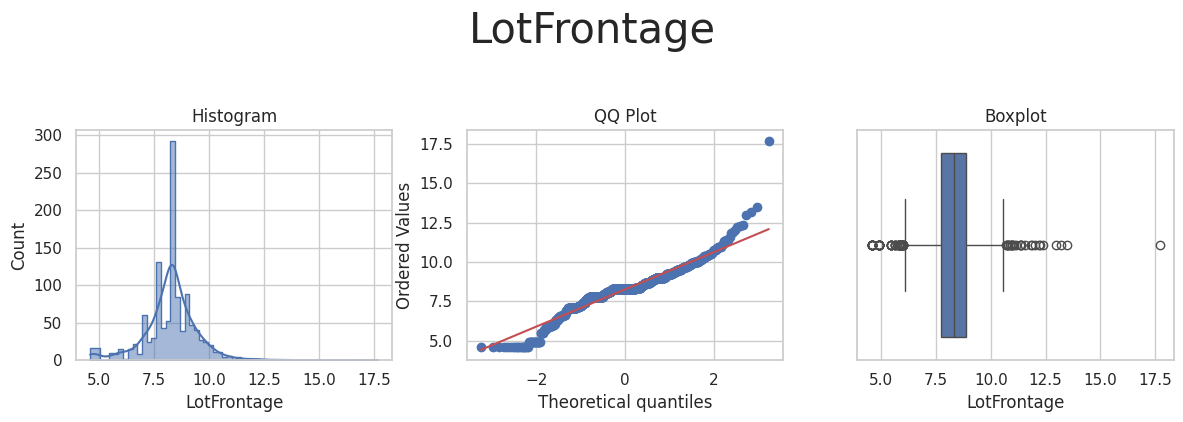

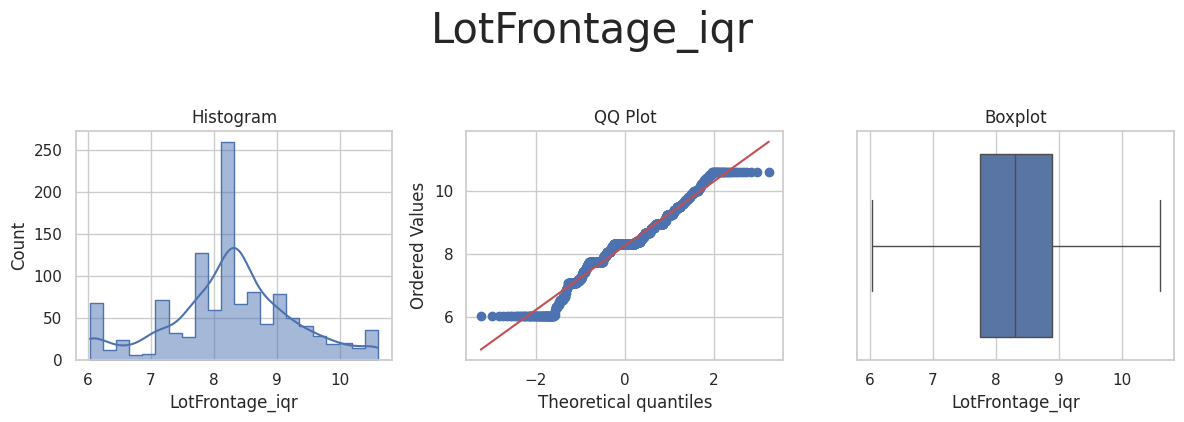



* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_iqr'] 



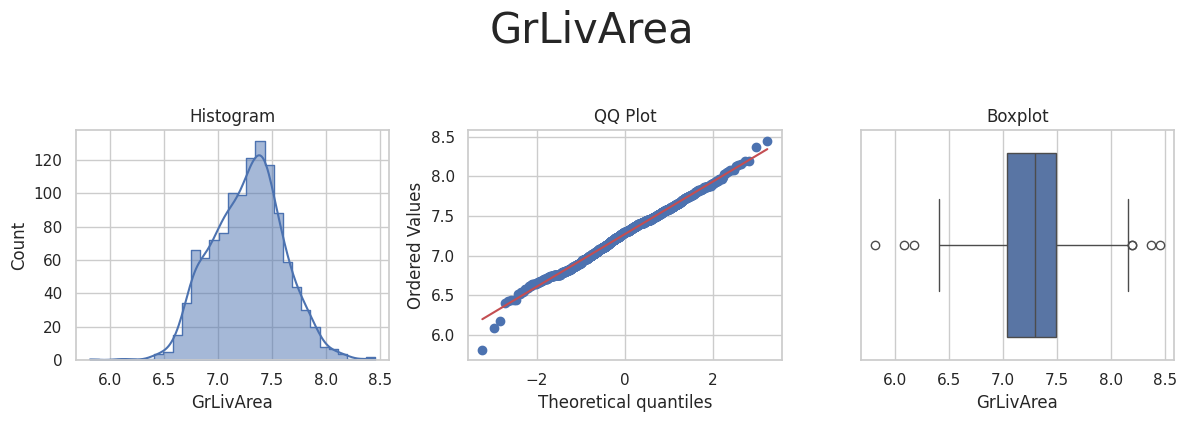

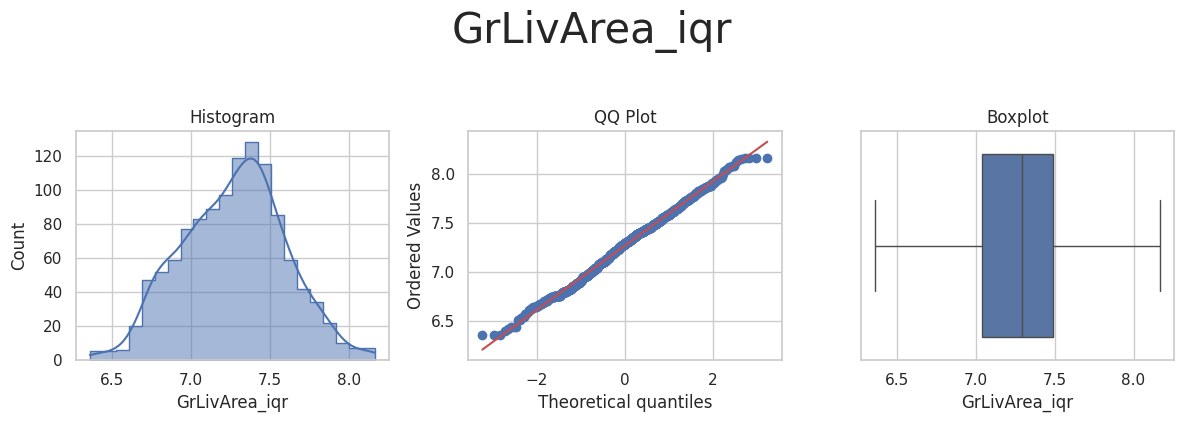



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_iqr'] 



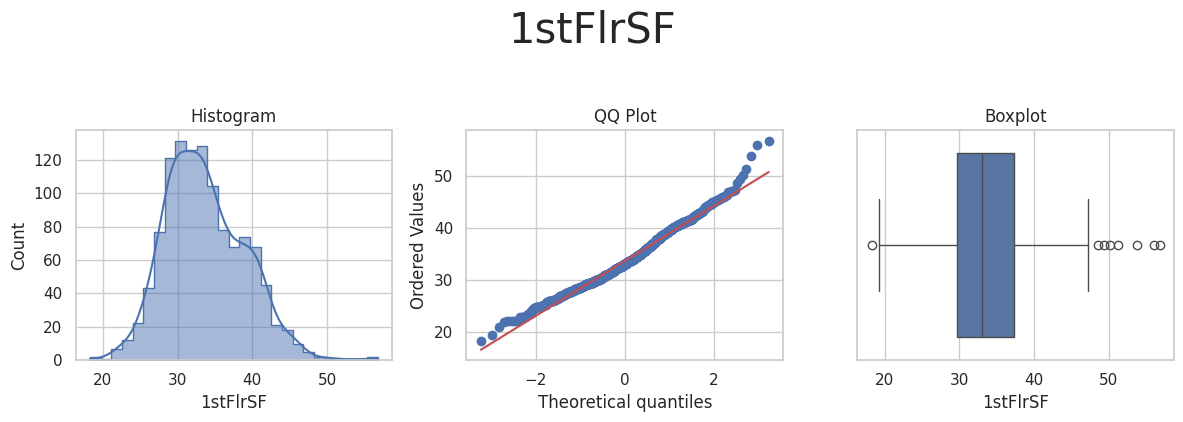

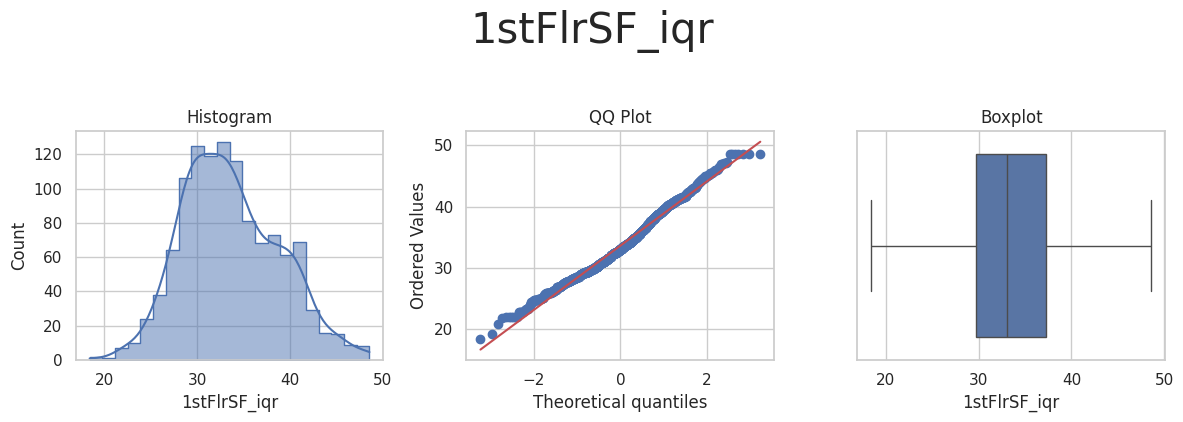



* Variable Analyzed: BsmtUnfSF
* Applied transformation: ['BsmtUnfSF_iqr'] 



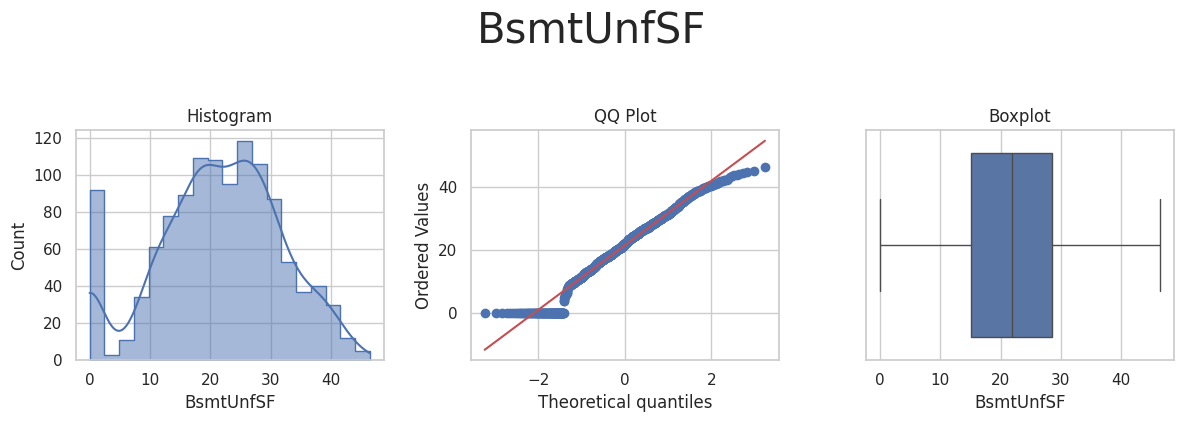

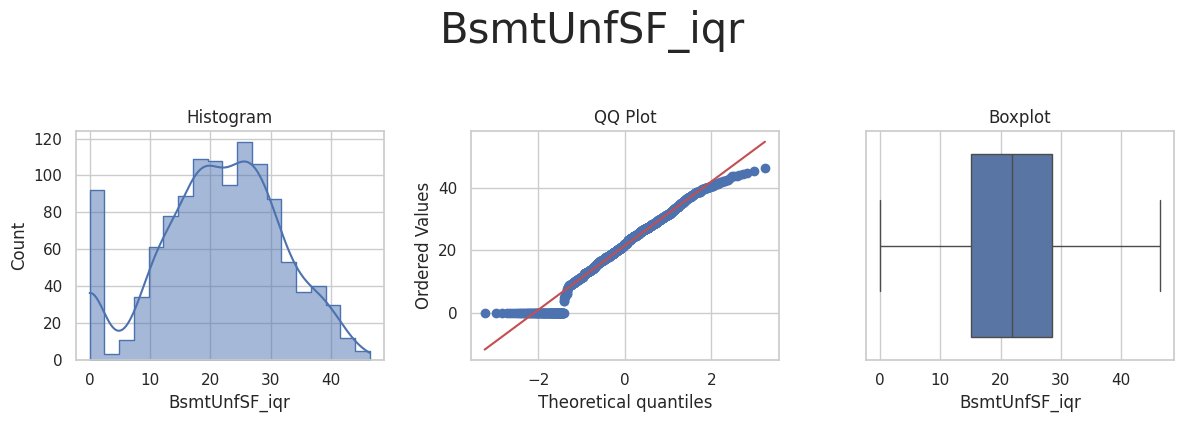



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_iqr'] 



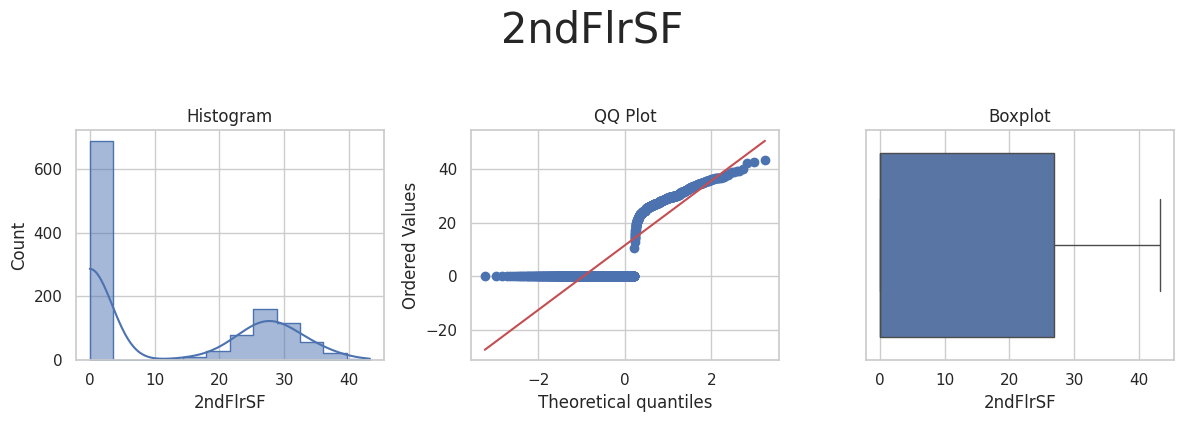

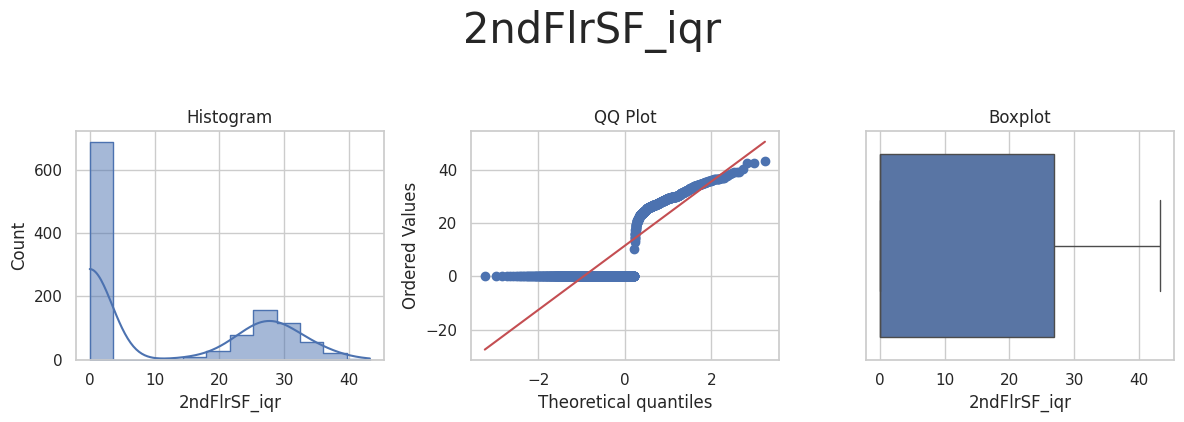



* Variable Analyzed: BsmtFinSF1
* Applied transformation: ['BsmtFinSF1_iqr'] 



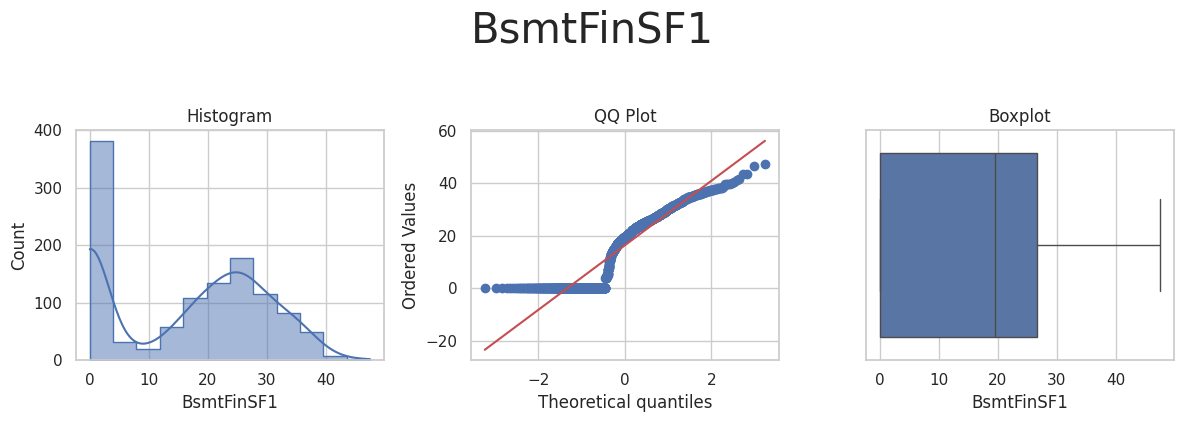

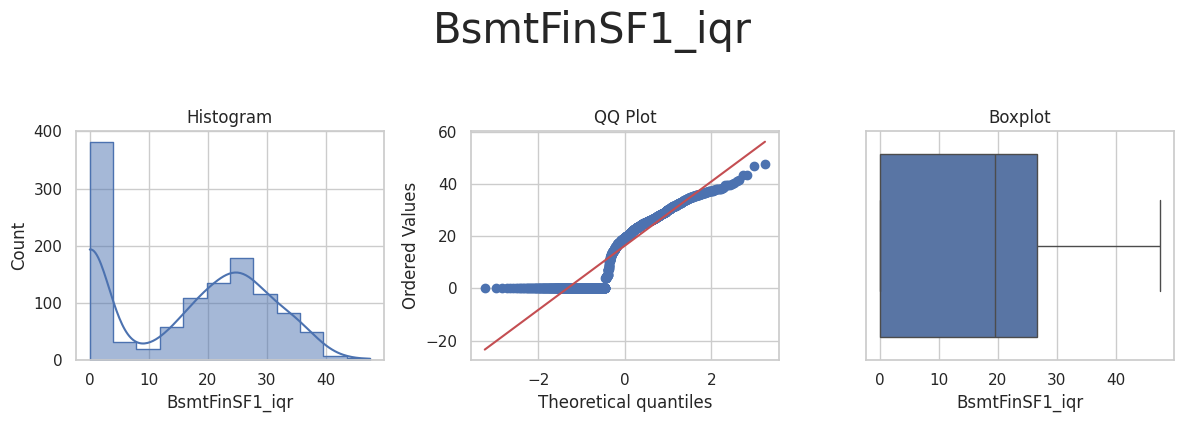

In [21]:
df_engineering = FeatureEngineeringAnalysis(
    df=df_engineering, analysis_type="outlier_winsorizer"
)

In [22]:
# Before transformation: Check original statistics
print("=== Before Winsorizer ===")
print(TrainSet[variables_engineering].describe().T)

# Apply winsorizer
winsoriser = Winsorizer(
    capping_method="iqr", tail="both", fold=1.5, variables=variables_engineering
)
TrainSet = winsoriser.fit_transform(TrainSet)
TestSet = winsoriser.transform(TestSet)  

print("* Outlier winsoriser transformation done!")

# After transformation: Check updated statistics
print("\n=== After Winsorizer ===")
print(TrainSet[variables_engineering].describe().T)


=== Before Winsorizer ===
              count       mean        std        min        25%        50%  \
LotArea      1168.0   9.112796   0.518370   7.170120   8.934521   9.160362   
MasVnrArea   1168.0   5.948203   8.223519   0.000000   0.000000   0.000000   
OpenPorchSF  1168.0   4.818335   4.984922   0.000000   0.000000   5.099020   
LotFrontage  1168.0   8.246471   1.224567   4.582576   7.745967   8.306624   
GrLivArea    1168.0   7.271240   0.331280   5.811141   7.037905   7.294038   
1stFlrSF     1168.0  33.655528   5.318701  18.275667  29.732137  33.045423   
BsmtUnfSF    1168.0  21.480987  10.329967   0.000000  15.099559  21.965880   
2ndFlrSF     1168.0  11.559630  14.147314   0.000000   0.000000   0.000000   
BsmtFinSF1   1168.0  16.371160  13.115747   0.000000   0.000000  19.480756   

                   75%        max  
LotArea       9.358890  12.279532  
MasVnrArea   12.893786  40.000000  
OpenPorchSF   8.246211  23.388031  
LotFrontage   8.888194  17.691806  
GrLivArea    

---

4. SmartCorrelatedSelection Variables

In [23]:
from feature_engine.selection import SmartCorrelatedSelection

corr_sel = SmartCorrelatedSelection(
    variables=None, method="spearman", threshold=0.8, selection_method="variance"
)

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'LotArea', 'LotArea_iqr'},
 {'MasVnrArea', 'MasVnrArea_iqr'},
 {'OpenPorchSF', 'OpenPorchSF_iqr'},
 {'LotFrontage', 'LotFrontage_iqr'},
 {'GrLivArea', 'GrLivArea_iqr'},
 {'1stFlrSF', '1stFlrSF_iqr'},
 {'BsmtUnfSF', 'BsmtUnfSF_iqr'},
 {'2ndFlrSF', '2ndFlrSF_iqr'},
 {'BsmtFinSF1', 'BsmtFinSF1_iqr'}]

In [24]:
corr_sel.features_to_drop_

['LotArea_iqr',
 'MasVnrArea_iqr',
 'OpenPorchSF_iqr',
 'LotFrontage_iqr',
 'GrLivArea_iqr',
 '1stFlrSF_iqr',
 'BsmtUnfSF_iqr',
 '2ndFlrSF_iqr',
 'BsmtFinSF1']

## Save Feature Engineered Datasets

In [25]:
import os

# Define the output directory
output_dir = "outputs/datasets/feature_engineered"
os.makedirs(output_dir, exist_ok=True)

# Display the output directory path
output_dir


'outputs/datasets/feature_engineered'

In [26]:
# Save the transformed datasets after Feature Engineering
TrainSet.to_csv("outputs/datasets/feature_engineered/Train_FE.csv", index=False)
TestSet.to_csv("outputs/datasets/feature_engineered/Test_FE.csv", index=False)

print("* Feature engineered datasets saved!")


* Feature engineered datasets saved!


---

## Summary and Next Steps

**Summary**

Feature Engineering Transformers Applied:

- Ordinal categorical encoding applied to:  
  ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

- Numerical transformation:
  - LogTransformer:  
    ['LotArea', 'MasVnrArea', 'OpenPorchSF', 'LotFrontage', 'GrLivArea']
  - PowerTransformer (Yeo-Johnson):  
    ['1stFlrSF', '2ndFlrSF', 'BsmtUnfSF', 'BsmtFinSF1']

- Outlier Winsorizer applied to:  
  ['GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']

- Correlated features dropped using SmartCorrelatedSelection:  
  ['LotArea_iqr', 'MasVnrArea_iqr', 'OpenPorchSF_iqr', 'LotFrontage_iqr', 'GrLivArea_iqr',
   '1stFlrSF_iqr', 'BsmtUnfSF', '2ndFlrSF_iqr', 'BsmtFinSF1_iqr']

**Next Step**:  
- Proceed to Modeling & Evaluation Notebook to build and assess regression models.
